This notebook contains the EDA of the subset of data extracted from the **Exploratory_Data_Analysis_for_entire_dataset.ipynb**

### Importing Required Libraries

In [1]:
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import nltk
from nltk.util import ngrams
from collections import Counter
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

import warnings
warnings.filterwarnings('ignore')

### Reading the dataset

In [2]:
data = pd.read_excel(r'Online_Retail.xlsx')

In [3]:
df = data[(data['Quantity'] > 0) & (data['UnitPrice'] > 0)]

In [4]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [5]:
df.shape

(530104, 8)

### Exploratory Data Analysis

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 530104 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    530104 non-null  object        
 1   StockCode    530104 non-null  object        
 2   Description  530104 non-null  object        
 3   Quantity     530104 non-null  int64         
 4   InvoiceDate  530104 non-null  datetime64[ns]
 5   UnitPrice    530104 non-null  float64       
 6   CustomerID   397884 non-null  float64       
 7   Country      530104 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 36.4+ MB


The CustomerID column is the only field with missing values, accounting for approximately 75% null entries in the dataset.

In [7]:
duplicate_CustomerID = df[df['CustomerID'].duplicated()]['CustomerID']
print(f"Number of Duplicate CustomerIDsIDs {duplicate_CustomerID.shape}")

non_duplicated_CustomerID = df['CustomerID'].unique()
print(f"Number of Unique CustomerIDs {non_duplicated_CustomerID.shape}")

Number of Duplicate CustomerIDsIDs (525765,)
Number of Unique CustomerIDs (4339,)


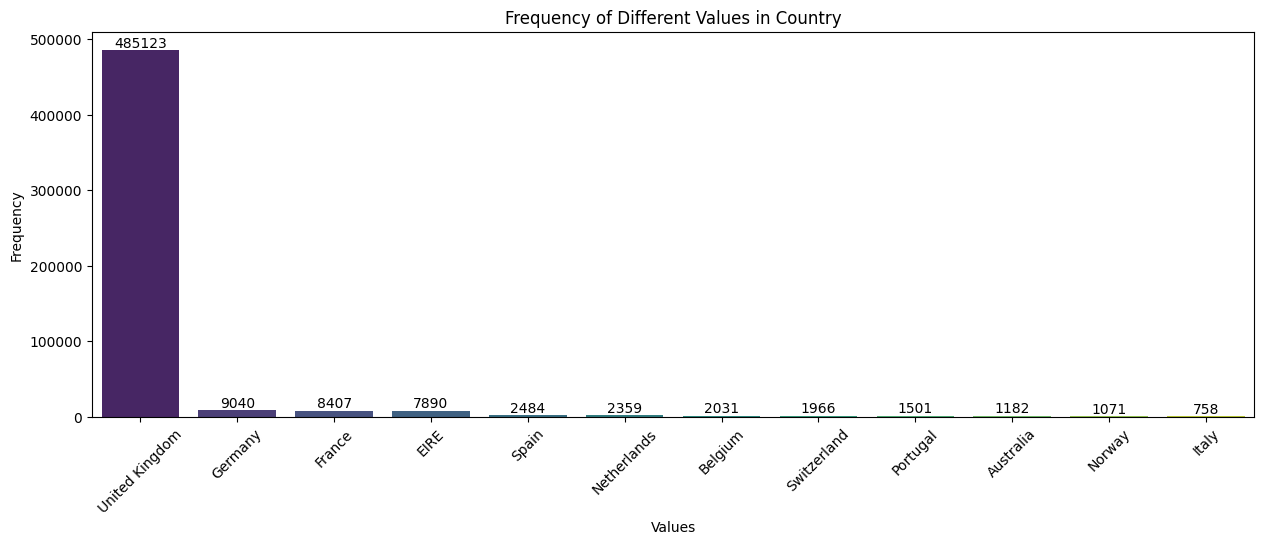

In [8]:
value_counts = df['Country'].value_counts()[:12]

# Bar plot using Seaborn
plt.figure(figsize=(15, 5))
ax = sns.barplot(x = value_counts.index, y = value_counts.values, palette = "viridis")
plt.title('Frequency of Different Values in Country')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.xticks(rotation=45)

# Add values on top of bars
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 5), 
                textcoords='offset points')
plt.show()

The analysis of this subset indicates that approximately 92% of the audience originates from the United Kingdom, reaffirming its dominance as the primary demographic

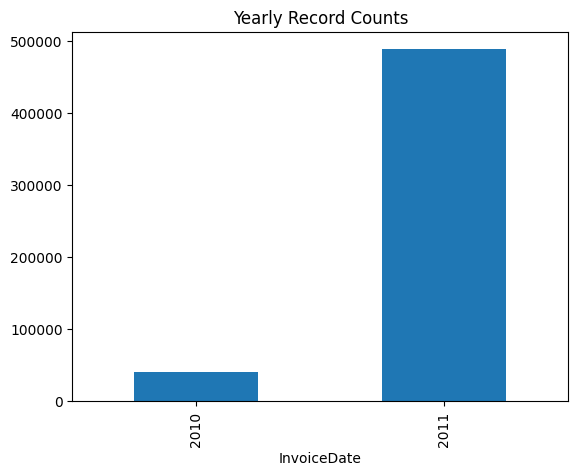

In [9]:
yearly_counts_pos = df.groupby(df['InvoiceDate'].dt.year).size()
yearly_counts_pos.plot(kind='bar', title='Yearly Record Counts')
plt.show()

In [10]:
yearly_counts_pos

InvoiceDate
2010     41480
2011    488624
dtype: int64

- 92 % of the Invoices are generated in the year 2011
- Since there is a lot of invoices generated in the year 2011 than in 2010, in the below cells there is a comparison in the trend and the keywords available for 2010 and 2011

### Data Description

In [11]:
df.describe()

,Quantity,InvoiceDate,UnitPrice,CustomerID
count,530104.000000,530104,530104.000000,397884.000000
mean,10.542037,2011-07-04 20:16:05.225087744,3.907625,15294.423453
min,1.000000,2010-12-01 08:26:00,0.001000,12346.000000
25%,1.000000,2011-03-28 12:22:00,1.250000,13969.000000
50%,3.000000,2011-07-20 12:58:00,2.080000,15159.000000
75%,10.000000,2011-10-19 12:39:00,4.130000,16795.000000
max,80995.000000,2011-12-09 12:50:00,13541.330000,18287.000000
std,155.524124,NaN,35.915681,1713.141560


- The standard deviation for the subset of data has decreased compared to the overall dataset, with Quantity reducing from 218.081158 to 155.524124 and UnitPrice decreasing from 96.759853 to 35.915681
- Still the standard deviation for Quantity seems high an comaring mean and max for quantity shows the possibility of outliers

### Data Distribution for Quantity

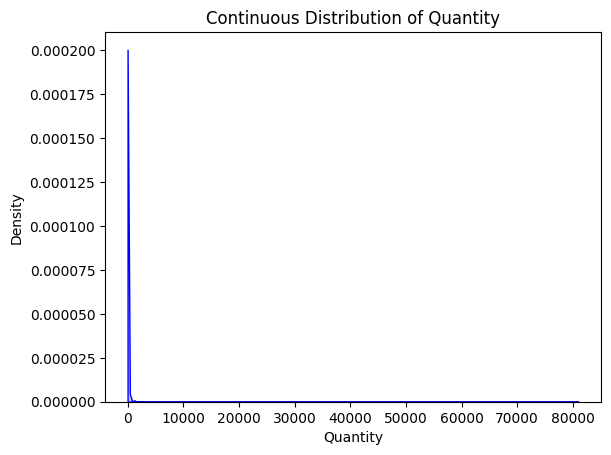

In [12]:
sns.kdeplot(df['Quantity'], shade=True, color='blue')
plt.title('Continuous Distribution of Quantity')
plt.xlabel('Quantity')
plt.ylabel('Density')
plt.show()

The Quantity variable exhibits a high degree of skewness, specifically a positive or right-skewed distribution

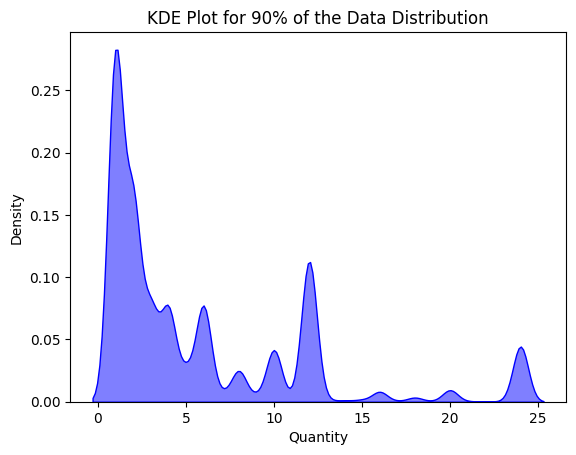

In [13]:
percentile_90 = df['Quantity'].quantile(0.9)

# Plot the KDE
sns.kdeplot(df[df['Quantity'] <= percentile_90]['Quantity'], fill = True, color = 'blue', alpha = 0.5)
plt.title('KDE Plot for 90% of the Data Distribution')
plt.xlabel('Quantity')
plt.ylabel('Density')
plt.show()

- So the outlier lies above the 90% of the data here
- The data distribution is still skewed with multiple peaks which suggests the possibility of subgroups present in the dataset
- A significant portion of the data is concentrated in the lower range (close to 0 to 5), as evident from the sharp, high peak in this region.

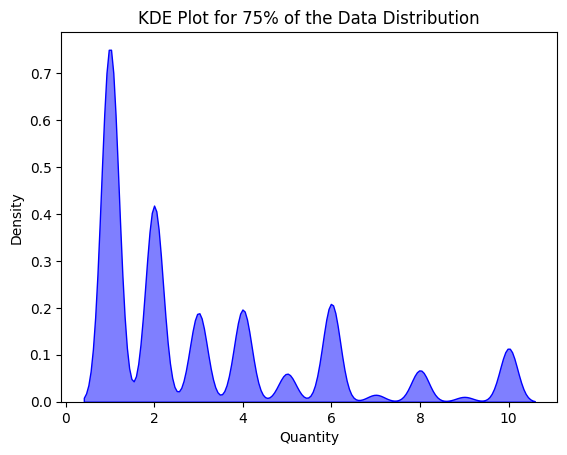

In [14]:
percentile_75 = df['Quantity'].quantile(0.75)

# Plot the KDE
sns.kdeplot(df[df['Quantity'] <= percentile_75]['Quantity'], fill = True, color = 'blue', alpha = 0.5)
plt.title('KDE Plot for 75% of the Data Distribution')
plt.xlabel('Quantity')
plt.ylabel('Density')
plt.show()

- This distribution is highly non-uniform and skewness still persists

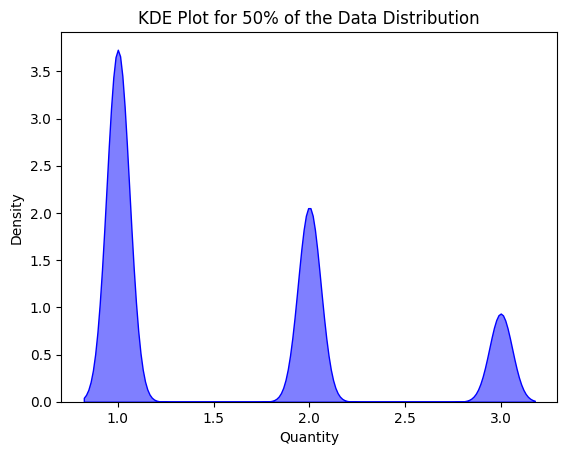

In [15]:
percentile_50 = df['Quantity'].quantile(0.50)

# Plot the KDE
sns.kdeplot(df[df['Quantity'] <= percentile_50]['Quantity'], fill = True, color = 'blue', alpha = 0.5)
plt.title('KDE Plot for 50% of the Data Distribution')
plt.xlabel('Quantity')
plt.ylabel('Density')
plt.show()

- There are only 3 values in this subset, with maximum density for value 1

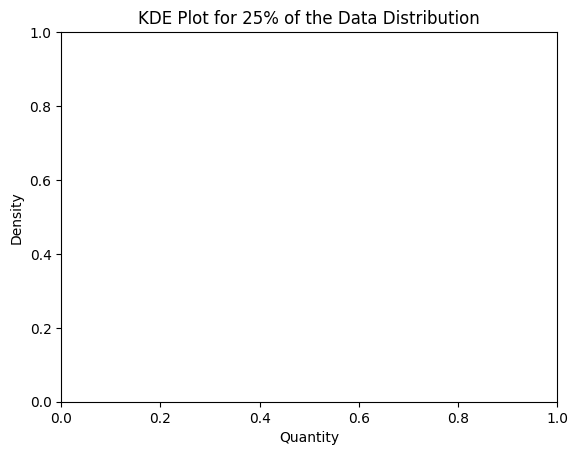

In [16]:
percentile_25 = df['Quantity'].quantile(0.25)

# Plot the KDE
sns.kdeplot(df[df['Quantity'] <= percentile_25]['Quantity'], fill = True, color = 'blue', alpha = 0.5)
plt.title('KDE Plot for 25% of the Data Distribution')
plt.xlabel('Quantity')
plt.ylabel('Density')
plt.show()

- This shows that the data subset is uniform, with no variation
- Since the 25th percentile of the data is 1 and all values in this subset are 1, the dataset for this subset lacks variability

### Data Distribution for UnitPrice

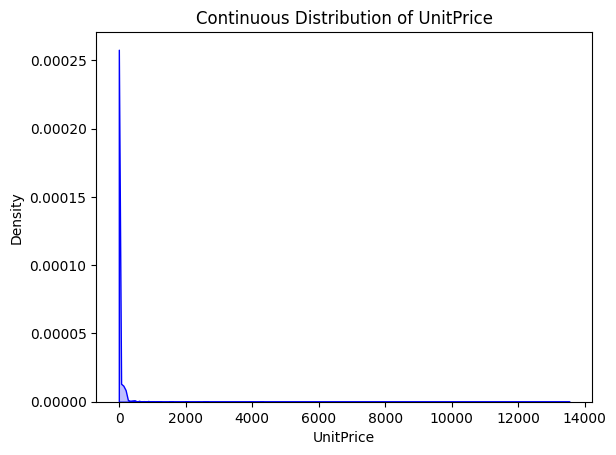

In [17]:
sns.kdeplot(df['UnitPrice'], shade=True, color='blue')
plt.title('Continuous Distribution of UnitPrice')
plt.xlabel('UnitPrice')
plt.ylabel('Density')
plt.show()

- The UnitPrice variable exhibits a high degree of skewness, specifically a positive or right-skewed distribution

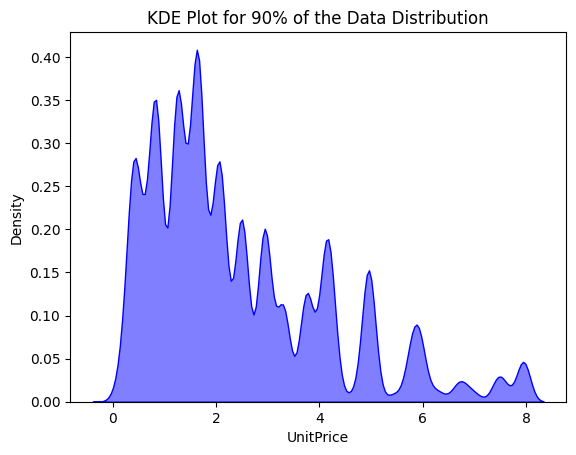

In [18]:
percentile_90 = df['UnitPrice'].quantile(0.9)

# Plot the KDE
sns.kdeplot(df[df['UnitPrice'] <= percentile_90]['UnitPrice'], fill = True, color = 'blue', alpha = 0.5)
plt.title('KDE Plot for 90% of the Data Distribution')
plt.xlabel('UnitPrice')
plt.ylabel('Density')
plt.show()

- This data subset distribution shows that there is some variation in the data
- It also tells us that the outlier is above the 90 percentile value

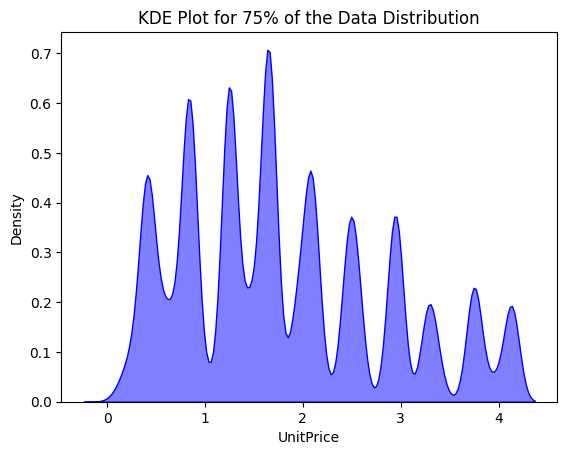

In [19]:
percentile_75 = df['UnitPrice'].quantile(0.75)

# Plot the KDE
sns.kdeplot(df[df['UnitPrice'] <= percentile_75]['UnitPrice'], fill = True, color = 'blue', alpha = 0.5)
plt.title('KDE Plot for 75% of the Data Distribution')
plt.xlabel('UnitPrice')
plt.ylabel('Density')
plt.show()

The data looks centered but there is a lot of variation in the data

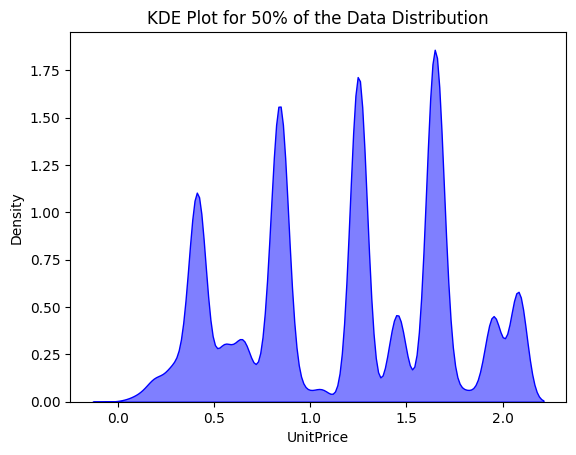

In [20]:
percentile_50 = df['UnitPrice'].quantile(0.50)

# Plot the KDE
sns.kdeplot(df[df['UnitPrice'] <= percentile_50]['UnitPrice'], fill = True, color = 'blue', alpha = 0.5)
plt.title('KDE Plot for 50% of the Data Distribution')
plt.xlabel('UnitPrice')
plt.ylabel('Density')
plt.show()

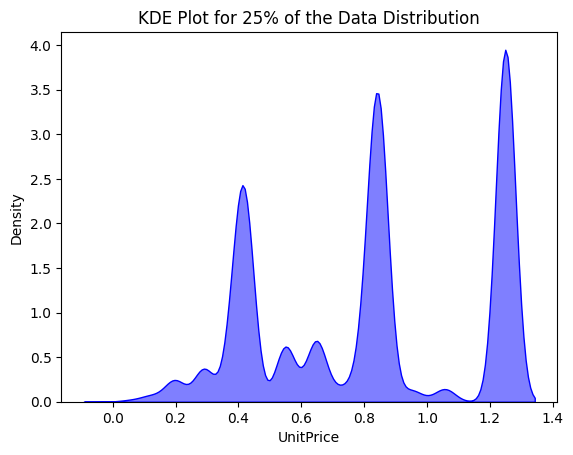

In [21]:
percentile_25 = df['UnitPrice'].quantile(0.25)

# Plot the KDE
sns.kdeplot(df[df['UnitPrice'] <= percentile_25]['UnitPrice'], fill = True, color = 'blue', alpha = 0.5)
plt.title('KDE Plot for 25% of the Data Distribution')
plt.xlabel('UnitPrice')
plt.ylabel('Density')
plt.show()

### Checking Outliers

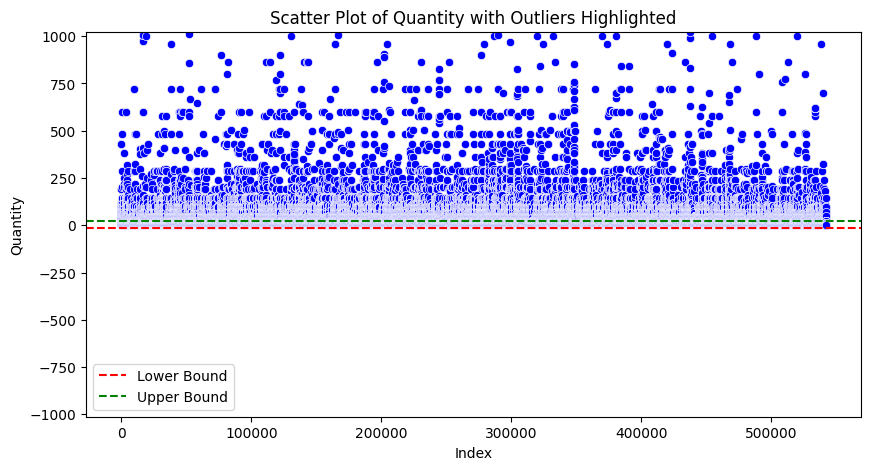

In [22]:
# Calculate IQR
Q1 = df['Quantity'].quantile(0.25)
Q3 = df['Quantity'].quantile(0.75)
IQR = Q3 - Q1

# Define bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify the outliers
outliers_lower = df[df['Quantity'] < lower_bound]
outliers_upper = df[df['Quantity'] > upper_bound]


plt.figure(figsize=(10, 5))
sns.scatterplot(data=df, x=df.index, y='Quantity', color='blue')
plt.axhline(lower_bound, color='red', linestyle='--', label='Lower Bound')
plt.axhline(upper_bound, color='green', linestyle='--', label='Upper Bound')
plt.ylim(lower_bound - 1000, upper_bound + 1000)  # Adjust limits for better visibility
plt.title('Scatter Plot of Quantity with Outliers Highlighted')
plt.xlabel('Index')
plt.ylabel('Quantity')
plt.legend()
plt.show()

In [23]:
# Calculate IQR
Q1 = df['Quantity'].quantile(0.25)
Q3 = df['Quantity'].quantile(0.75)
IQR = Q3 - Q1

# Define bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify outliers
outliers = df[(df['Quantity'] < lower_bound) | (df['Quantity'] > upper_bound)]

# Count of outliers
outlier_count = outliers.shape[0]
print(f"Number of outliers: {outlier_count}")

Number of outliers: 56363


- Since we dropped all the data points with negative quantity, we can now see outliers on the positive side
- Still the variable quantity has got a lot of outliers
- Quantity Variable has got almost 11 % outliers

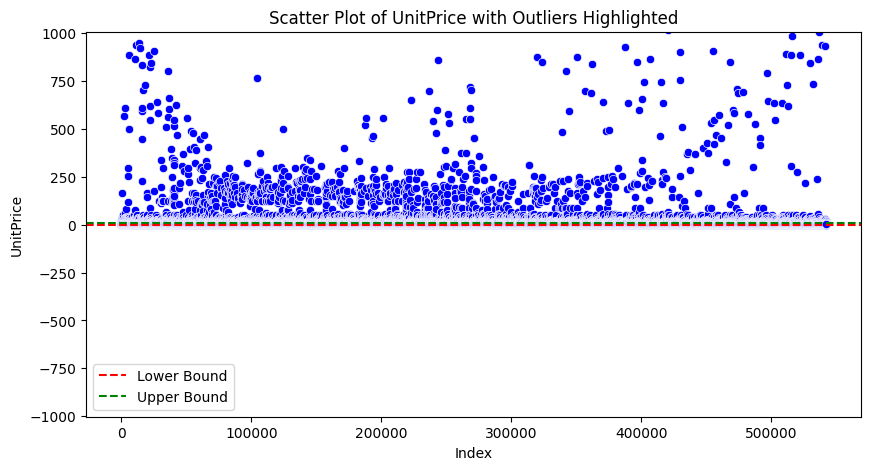

In [24]:
# Calculate IQR
Q1 = df['UnitPrice'].quantile(0.25)
Q3 = df['UnitPrice'].quantile(0.75)
IQR = Q3 - Q1

# Define bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify the outliers
outliers_lower = df[df['UnitPrice'] < lower_bound]
outliers_upper = df[df['UnitPrice'] > upper_bound]


plt.figure(figsize=(10, 5))
sns.scatterplot(data=df, x=df.index, y='UnitPrice', color='blue')
plt.axhline(lower_bound, color='red', linestyle='--', label='Lower Bound')
plt.axhline(upper_bound, color='green', linestyle='--', label='Upper Bound')
plt.ylim(lower_bound - 1000, upper_bound + 1000)  # Adjust limits for better visibility
plt.title('Scatter Plot of UnitPrice with Outliers Highlighted')
plt.xlabel('Index')
plt.ylabel('UnitPrice')
plt.legend()
plt.show()

In [25]:
# Calculate IQR
Q1 = df['UnitPrice'].quantile(0.25)
Q3 = df['UnitPrice'].quantile(0.75)
IQR = Q3 - Q1

# Define bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify outliers
outliers = df[(df['UnitPrice'] < lower_bound) | (df['UnitPrice'] > upper_bound)]

# Count of outliers
outlier_count = outliers.shape[0]
print(f"Number of outliers: {outlier_count}")

Number of outliers: 37999


- UnitPrice has got almost 7 % outliers, and these outliers needs to be investigated

### Extracting Year, Month, Day, Day of Week, and Hour

In [26]:
df['Year'] = df['InvoiceDate'].dt.year
df['Month'] = df['InvoiceDate'].dt.month
df['Day'] = df['InvoiceDate'].dt.day
df['DayOfWeek'] = df['InvoiceDate'].dt.day_name()  
df['Hour'] = df['InvoiceDate'].dt.hour

### Exploring the trends and patterns of 2010

In [27]:
year_2010 = df[df['Year'] == 2010]

In [28]:
year_2010.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Year,Month,Day,DayOfWeek,Hour
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,2010,12,1,Wednesday,8
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010,12,1,Wednesday,8
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,2010,12,1,Wednesday,8
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010,12,1,Wednesday,8
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010,12,1,Wednesday,8


In [29]:
year_2010['Year'].unique()

array([2010], dtype=int32)

In [30]:
year_2010.shape

(41480, 13)

In [31]:
year_2010.describe()

,Quantity,InvoiceDate,UnitPrice,CustomerID,Year,Month,Day,Hour
count,41480.000000,41480,41480.000000,26157.000000,41480.0,41480.0,41480.000000,41480.000000
mean,8.660535,2010-12-10 16:48:02.074252544,4.819298,15529.182819,2010.0,12.0,10.129749,13.168226
min,1.000000,2010-12-01 08:26:00,0.070000,12347.000000,2010.0,12.0,1.000000,7.000000
25%,1.000000,2010-12-06 09:58:00,1.450000,14161.000000,2010.0,12.0,6.000000,11.000000
50%,2.000000,2010-12-09 14:09:00,2.550000,15570.000000,2010.0,12.0,9.000000,13.000000
75%,7.000000,2010-12-15 13:37:00,4.337500,17179.000000,2010.0,12.0,15.000000,15.000000
max,2880.000000,2010-12-23 17:41:00,13541.330000,18269.000000,2010.0,12.0,23.000000,20.000000
std,37.043391,NaN,69.814940,1740.336702,0.0,0.0,6.110070,2.364922


In [32]:
year_2010.info()

<class 'pandas.core.frame.DataFrame'>
Index: 41480 entries, 0 to 42480
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   InvoiceNo    41480 non-null  object        
 1   StockCode    41480 non-null  object        
 2   Description  41480 non-null  object        
 3   Quantity     41480 non-null  int64         
 4   InvoiceDate  41480 non-null  datetime64[ns]
 5   UnitPrice    41480 non-null  float64       
 6   CustomerID   26157 non-null  float64       
 7   Country      41480 non-null  object        
 8   Year         41480 non-null  int32         
 9   Month        41480 non-null  int32         
 10  Day          41480 non-null  int32         
 11  DayOfWeek    41480 non-null  object        
 12  Hour         41480 non-null  int32         
dtypes: datetime64[ns](1), float64(2), int32(4), int64(1), object(5)
memory usage: 3.8+ MB


### Analyzing Day-of-Week Trends

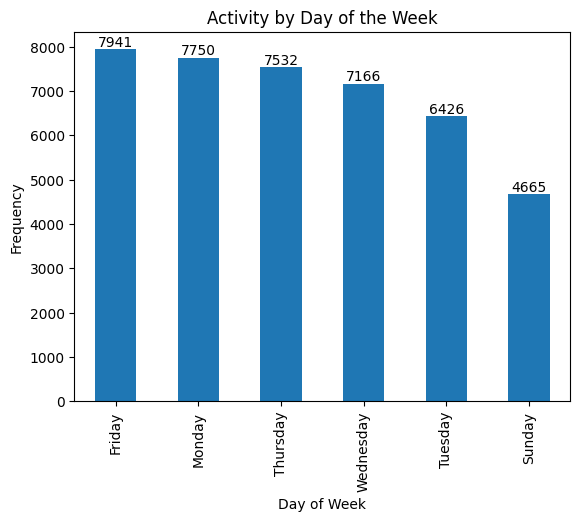

In [33]:
day_of_week_counts_2010 = year_2010['DayOfWeek'].value_counts()

# Visualization
day_of_week_counts_2010.plot(kind = 'bar', title = 'Activity by Day of the Week')
plt.xlabel('Day of Week')
plt.ylabel('Frequency')

for i, value in enumerate(day_of_week_counts_2010):
    plt.text(i, value + 0.5, str(value), ha='center', va='bottom', fontsize=10)
    
plt.show()


### Analyzing Month-of-Year Trends

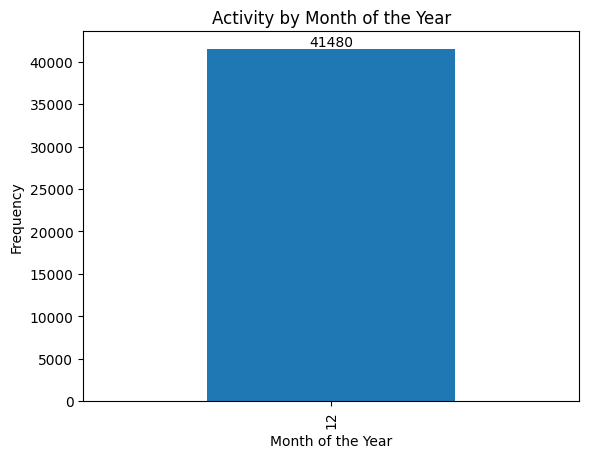

In [34]:
month_of_year_counts_2010 = year_2010['Month'].value_counts()

# Visualization
month_of_year_counts_2010.plot(kind = 'bar', title = 'Activity by Month of the Year')
plt.xlabel('Month of the Year')
plt.ylabel('Frequency')

for i, value in enumerate(month_of_year_counts_2010):
    plt.text(i, value + 0.5, str(value), ha='center', va='bottom', fontsize=10)
    
plt.show()


In [35]:
start_date_2010 = year_2010['InvoiceDate'].min()  # Find the earliest date
end_date_2010 = year_2010['InvoiceDate'].max()    # Find the latest date

# Calculate the range (difference between start and end date)
date_range_2010 = end_date_2010 - start_date_2010

print(f"Start Date: {start_date_2010}")
print(f"End Date: {end_date_2010}")
print(f"Date Range: {date_range_2010}")

Start Date: 2010-12-01 08:26:00
End Date: 2010-12-23 17:41:00
Date Range: 22 days 09:15:00


- Invoices are generated only in one month that is in December
- Maybe the data is been collected from December 2010 and hence most of the data is available in 2011 

### Analyzing Day-of-Month Trends

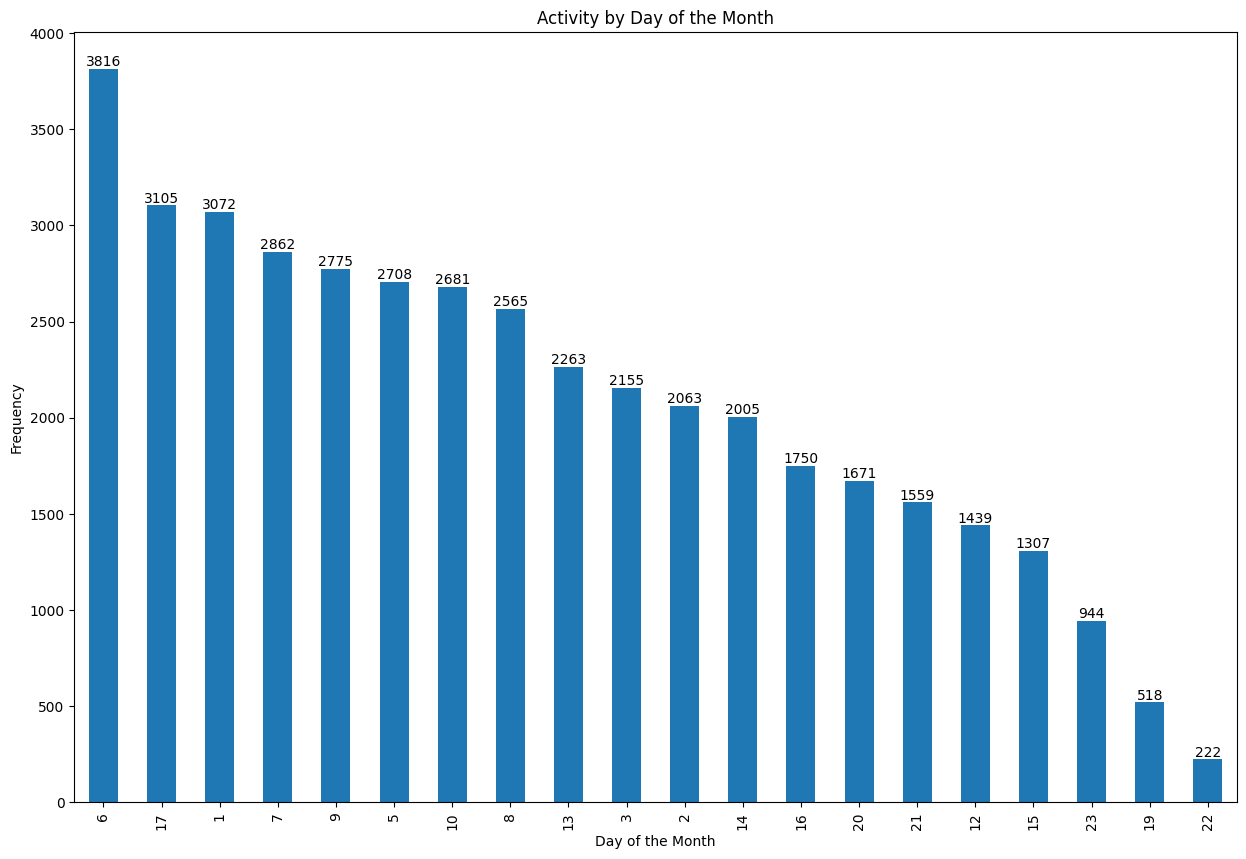

In [36]:
plt.figure(figsize=(15, 10))
Day_of_month_counts_2010 = year_2010['Day'].value_counts()

# Visualization
Day_of_month_counts_2010.plot(kind = 'bar', title = 'Activity by Day of the Month')
plt.xlabel('Day of the Month')
plt.ylabel('Frequency')

for i, value in enumerate(Day_of_month_counts_2010):
    plt.text(i, value + 0.5, str(value), ha='center', va='bottom', fontsize=10)
    
plt.show()


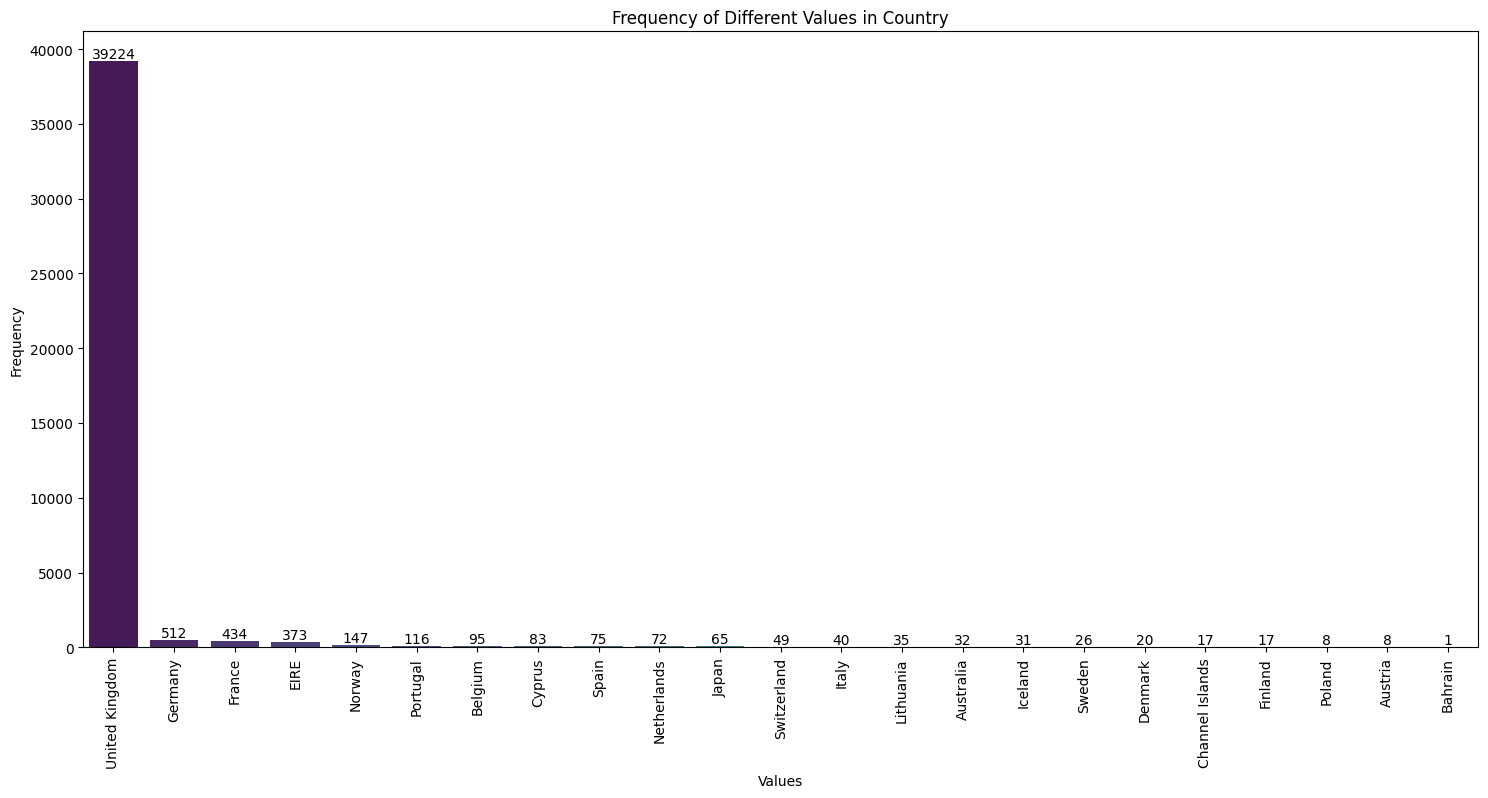

In [37]:
value_counts_2010 = year_2010['Country'].value_counts()

# Bar plot using Seaborn
plt.figure(figsize = (18, 8))
ax = sns.barplot(x = value_counts_2010.index, y = value_counts_2010.values, palette = "viridis")
plt.title('Frequency of Different Values in Country')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.xticks(rotation = 90)

# Add values on top of bars
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center', fontsize = 10, color = 'black', xytext = (0, 5), 
                textcoords = 'offset points')
plt.show()

### Lets have a check on what are the top keywords(Description) 

In [38]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

In [39]:
def clean_text(text, stop_words):
    # Ensure the input is a string before applying .lower()
    text = str(text).lower()

    # Remove non-alphanumeric characters
    text = re.sub(r"[^a-zA-Z\s]", "", text)
    
    # Split into words and filter stopwords
    words = [word for word in text.split() if word.isalnum() and word not in stop_words] 

    # Apply lemmatization
    words = [lemmatizer.lemmatize(word) for word in words]

    # Apply lemmatization
    words = [lemmatizer.lemmatize(word) for word in words]

    # Returning list of cleaned words
    return words 
    


In [40]:
# Apply the clean_text function to the Description column
year_2010['Cleaned_Description'] = year_2010['Description'].apply(lambda x: clean_text(x, stop_words))

# Convert list of words back into a single string for each row
year_2010['Cleaned_Description_Joined'] = year_2010['Cleaned_Description'].apply(lambda x: ' '.join(x))

# Filtering nan values
year_2010 = year_2010[year_2010['Cleaned_Description_Joined'] != 'nan']

In [41]:
year_2010.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Year,Month,Day,DayOfWeek,Hour,Cleaned_Description,Cleaned_Description_Joined
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,2010,12,1,Wednesday,8,"[white, hanging, heart, tlight, holder]",white hanging heart tlight holder
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010,12,1,Wednesday,8,"[white, metal, lantern]",white metal lantern
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,2010,12,1,Wednesday,8,"[cream, cupid, heart, coat, hanger]",cream cupid heart coat hanger
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010,12,1,Wednesday,8,"[knitted, union, flag, hot, water, bottle]",knitted union flag hot water bottle
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010,12,1,Wednesday,8,"[red, woolly, hottie, white, heart]",red woolly hottie white heart


In [42]:
year_2010.shape

(41480, 15)

### Get unigrams (single words)

In [43]:
# Tokenize the text into words for unigram analysis
all_words_2010 = [word for sublist in year_2010['Cleaned_Description_Joined'] for word in sublist.split()]
freq_unigrams_2010 = nltk.FreqDist(all_words_2010)

In [44]:
freq_unigrams_2010

FreqDist({'set': 3889, 'red': 3612, 'heart': 3569, 'retrospot': 2776, 'christmas': 2671, 'box': 2611, 'bag': 2551, 'pink': 2244, 'design': 2025, 'vintage': 1872, ...})

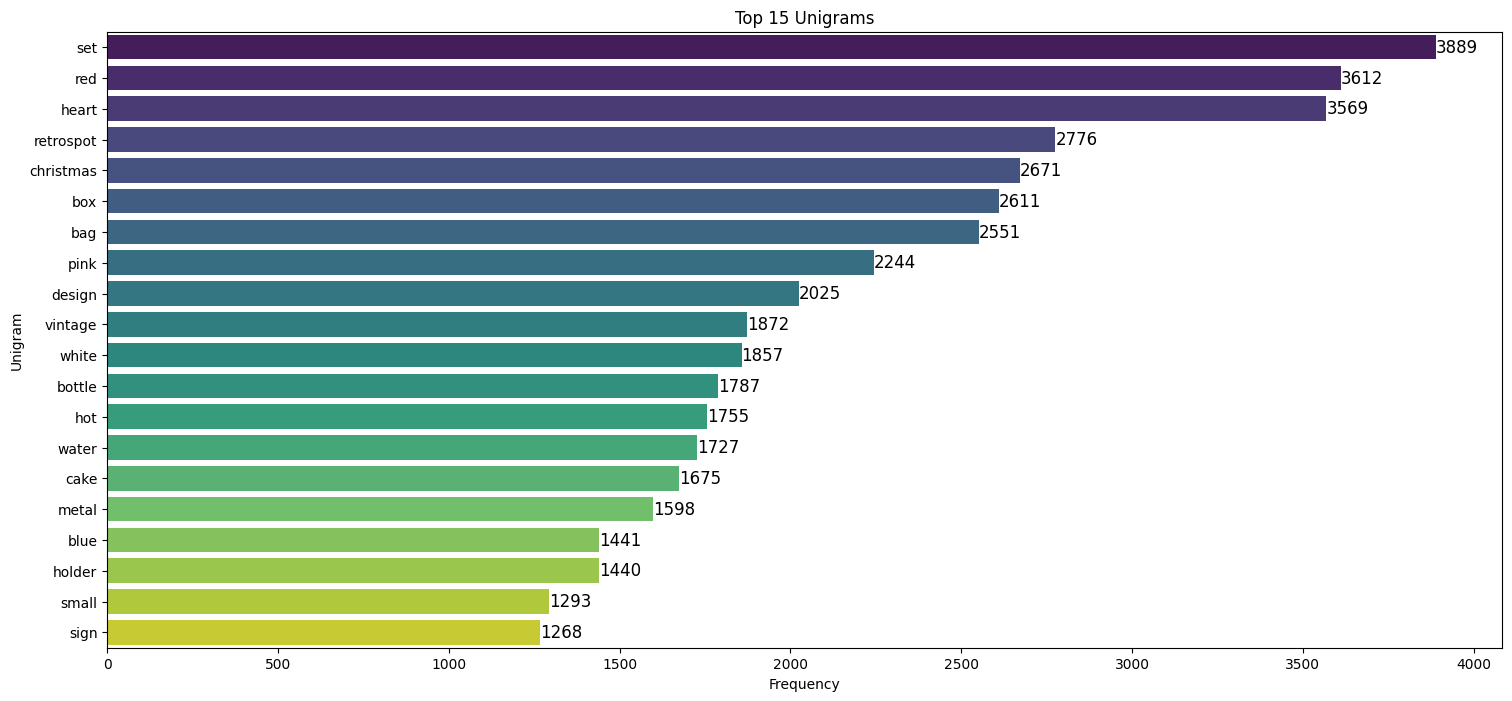

In [45]:
top_unigrams_2010 = freq_unigrams_2010.most_common(20)
top_unigrams_df_2010 = pd.DataFrame(top_unigrams_2010, columns=['Word', 'Frequency'])

# Plot the top unigrams
plt.figure(figsize=(18, 8))
ax = sns.barplot(x = 'Frequency', y = 'Word', data = top_unigrams_df_2010, palette = 'viridis')
plt.title('Top 15 Unigrams')
plt.xlabel('Frequency')
plt.ylabel('Unigram')

# Display the frequency on top of the bars
for i, v in enumerate(top_unigrams_df_2010['Frequency']):
    ax.text(v + 0.2, i, str(v), color='black', va='center', fontsize=12)

plt.show()

The unigram indicates that decorative items(metals, sign, holder) household accessories(bottle, box), seasonal and festive products(Christmas, cake) dominate the product descriptions.

### Get bigrams (pairs of words)

In [46]:
# Generate bigrams
all_bigrams_2010 = list(ngrams(all_words_2010, 2))
freq_bigrams_2010 = nltk.FreqDist(all_bigrams_2010)

In [47]:
freq_bigrams_2010

FreqDist({('hot', 'water'): 1691, ('water', 'bottle'): 1691, ('red', 'retrospot'): 1531, ('metal', 'sign'): 992, ('tlight', 'holder'): 924, ('hand', 'warmer'): 696, ('cake', 'case'): 583, ('jumbo', 'bag'): 546, ('hanging', 'heart'): 522, ('lunch', 'bag'): 455, ...})

- The bigrams highlight a clear focus on decorative("metal sign,", "tlight holder", "hanging heart"), seasonal("ribbon reel", "hand warmer"), and household products("hot water", "water bottle", "plaster tin", "lunch bag", "lunch box"), often described with functional or aesthetic keywords.
- Overall, the bigrams emphasize a mix of functional household goods, decorative products, and festive or vintage-themed items that likely cater to daily, seasonal, and gifting needs.

In [48]:
top_bigrams_2010 = freq_bigrams_2010.most_common(20)
top_bigrams_df_2010 = pd.DataFrame(top_bigrams_2010, columns=['Bigram', 'Frequency'])
top_bigrams_df_2010['Bigram'] = top_bigrams_df_2010['Bigram'].apply(lambda x: ' '.join(x))  

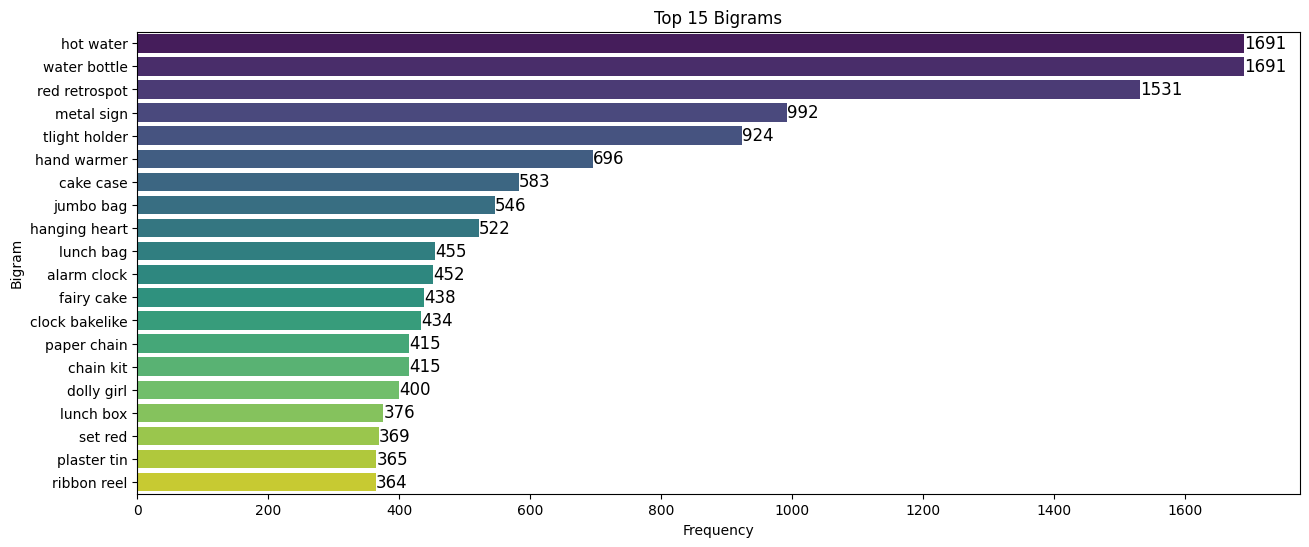

In [49]:
# Plot the top bigrams
plt.figure(figsize = (15, 6))
ax = sns.barplot(x = 'Frequency', y = 'Bigram', data = top_bigrams_df_2010, palette = 'viridis')
plt.title('Top 15 Bigrams')
plt.xlabel('Frequency')
plt.ylabel('Bigram')

# Display the frequency on top of the bars
for i, v in enumerate(top_bigrams_df_2010['Frequency']):
    ax.text(v + 0.2, i, str(v), color = 'black', va = 'center', fontsize = 12)

plt.show()

### Get trigrams (triples of words)

In [50]:
# Generate trigrams
all_trigrams_2010 = list(ngrams(all_words_2010, 3))
freq_trigrams_2010 = nltk.FreqDist(all_trigrams_2010)

In [51]:
freq_trigrams_2010

FreqDist({('hot', 'water', 'bottle'): 1691, ('alarm', 'clock', 'bakelike'): 434, ('paper', 'chain', 'kit'): 415, ('heart', 'tlight', 'holder'): 358, ('hanging', 'heart', 'tlight'): 327, ('bag', 'red', 'retrospot'): 279, ('jam', 'making', 'set'): 248, ('heart', 'hot', 'water'): 243, ('white', 'hanging', 'heart'): 239, ('magic', 'drawing', 'slate'): 221, ...})

In [52]:
top_trigrams_2010 = freq_trigrams_2010.most_common(15)
top_trigrams_df_2010 = pd.DataFrame(top_trigrams_2010, columns = ['Trigram', 'Frequency'])
top_trigrams_df_2010['Trigram'] = top_trigrams_df_2010['Trigram'].apply(lambda x: ' '.join(x))  # Convert tuple to string

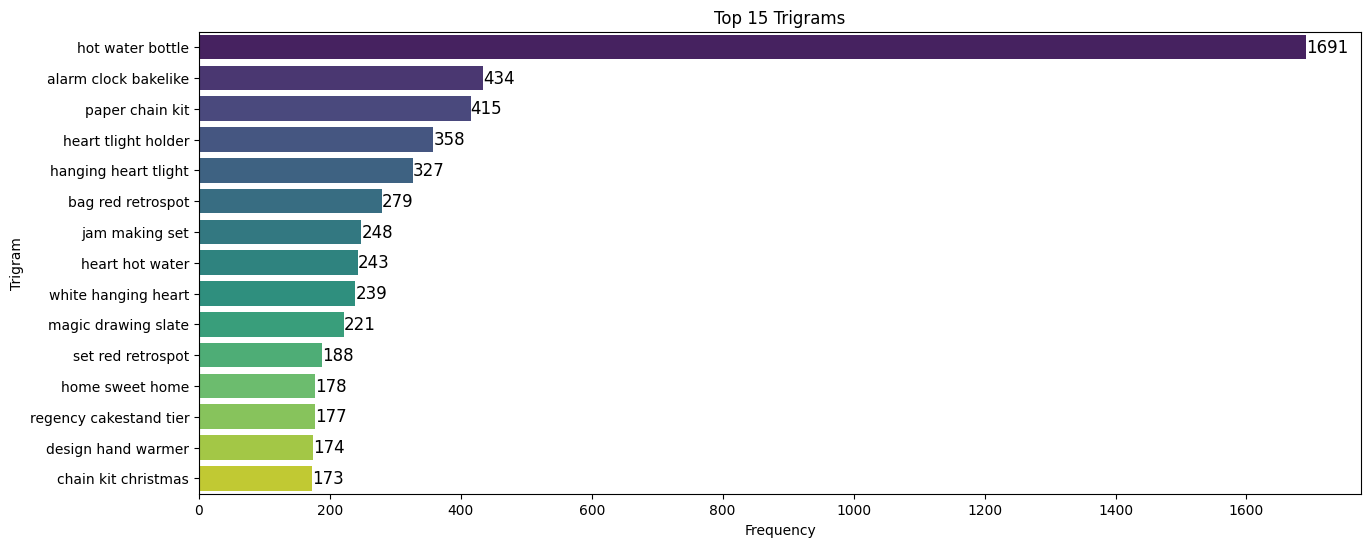

In [53]:
# Plot the top trigrams
plt.figure(figsize = (15, 6))
ax = sns.barplot(x = 'Frequency', y = 'Trigram', data = top_trigrams_df_2010, palette = 'viridis')
plt.title('Top 15 Trigrams')
plt.xlabel('Frequency')
plt.ylabel('Trigram')

# Display the frequency on top of the bars
for i, v in enumerate(top_trigrams_df_2010['Frequency']):
    ax.text(v + 0.2, i, str(v), color = 'black', va = 'center', fontsize = 12)

plt.show()

The trigrams provide deeper insights into the products, emphasizing functional, decorative, and festive items with vintage and themed designs.

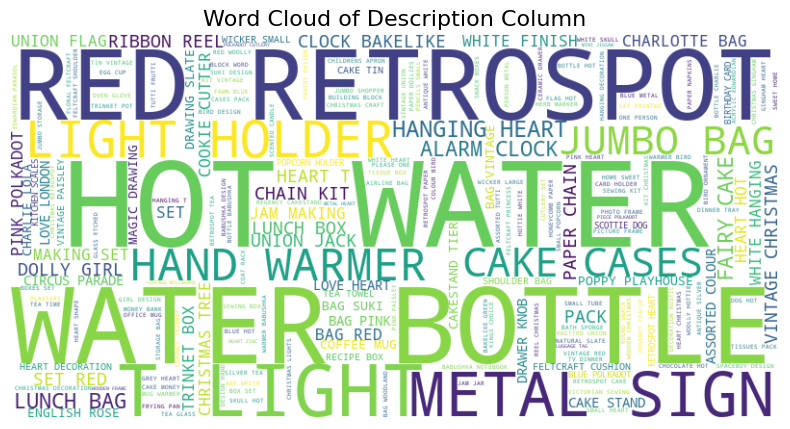

In [54]:
# Combine all sentences into a single string
text = " ".join(year_2010['Description'].dropna().astype(str))

# Generate a word cloudz
wordcloud = WordCloud(width = 800, height = 400, background_color = 'white').generate(text)

# Display the word cloud
plt.figure(figsize = (10, 5))
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.title('Word Cloud of Description Column', fontsize = 16)
plt.show()

The word cloud, unigram, bigram and trigram all of them show that the words are related to decorative, seasonal, festive, vintage, themed designs

### Exploring the trends and patterns of 2011

In [55]:
year_2011 = df[df['Year'] == 2011]

In [56]:
year_2011.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Year,Month,Day,DayOfWeek,Hour
42481,539993,22386,JUMBO BAG PINK POLKADOT,10,2011-01-04 10:00:00,1.95,13313.0,United Kingdom,2011,1,4,Tuesday,10
42482,539993,21499,BLUE POLKADOT WRAP,25,2011-01-04 10:00:00,0.42,13313.0,United Kingdom,2011,1,4,Tuesday,10
42483,539993,21498,RED RETROSPOT WRAP,25,2011-01-04 10:00:00,0.42,13313.0,United Kingdom,2011,1,4,Tuesday,10
42484,539993,22379,RECYCLING BAG RETROSPOT,5,2011-01-04 10:00:00,2.10,13313.0,United Kingdom,2011,1,4,Tuesday,10
42485,539993,20718,RED RETROSPOT SHOPPER BAG,10,2011-01-04 10:00:00,1.25,13313.0,United Kingdom,2011,1,4,Tuesday,10


In [57]:
year_2011.describe()

,Quantity,InvoiceDate,UnitPrice,CustomerID,Year,Month,Day,Hour
count,488624.000000,488624,488624.000000,371727.000000,488624.0,488624.000000,488624.000000,488624.000000
mean,10.701760,2011-07-22 08:15:56.926470912,3.830232,15277.904338,2011.0,7.183745,15.436141,13.067762
min,1.000000,2011-01-04 10:00:00,0.001000,12346.000000,2011.0,1.000000,1.000000,6.000000
25%,1.000000,2011-04-26 09:42:15,1.250000,13941.000000,2011.0,4.000000,8.000000,11.000000
50%,4.000000,2011-08-05 17:12:00,2.080000,15127.000000,2011.0,8.000000,15.000000,13.000000
75%,12.000000,2011-10-25 13:14:00,4.130000,16775.000000,2011.0,10.000000,23.000000,15.000000
max,80995.000000,2011-12-09 12:50:00,11062.060000,18287.000000,2011.0,12.000000,31.000000,20.000000
std,161.630065,NaN,31.394297,1710.000757,0.0,3.396974,8.718883,2.444745


In [58]:
year_2011.info()

<class 'pandas.core.frame.DataFrame'>
Index: 488624 entries, 42481 to 541908
Data columns (total 13 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    488624 non-null  object        
 1   StockCode    488624 non-null  object        
 2   Description  488624 non-null  object        
 3   Quantity     488624 non-null  int64         
 4   InvoiceDate  488624 non-null  datetime64[ns]
 5   UnitPrice    488624 non-null  float64       
 6   CustomerID   371727 non-null  float64       
 7   Country      488624 non-null  object        
 8   Year         488624 non-null  int32         
 9   Month        488624 non-null  int32         
 10  Day          488624 non-null  int32         
 11  DayOfWeek    488624 non-null  object        
 12  Hour         488624 non-null  int32         
dtypes: datetime64[ns](1), float64(2), int32(4), int64(1), object(5)
memory usage: 44.7+ MB


### Analyzing Day-of-Week Trends

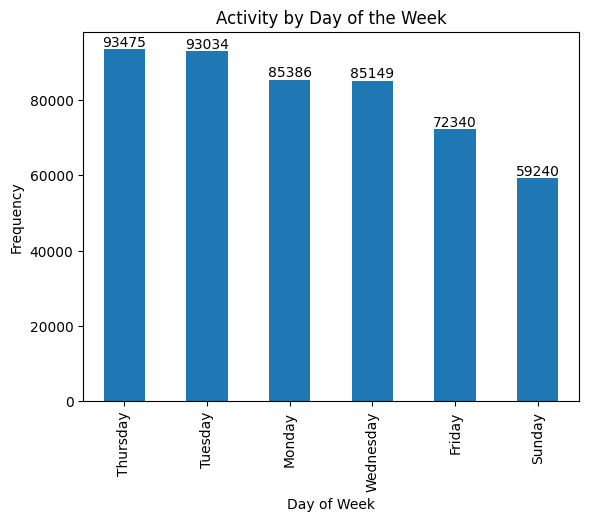

In [59]:
day_of_week_counts_2011 = year_2011['DayOfWeek'].value_counts()

# Visualization
day_of_week_counts_2011.plot(kind = 'bar', title = 'Activity by Day of the Week')
plt.xlabel('Day of Week')
plt.ylabel('Frequency')

for i, value in enumerate(day_of_week_counts_2011):
    plt.text(i, value + 0.5, str(value), ha='center', va='bottom', fontsize=10)
    
plt.show()


### Analyzing Month-of-Year Trends

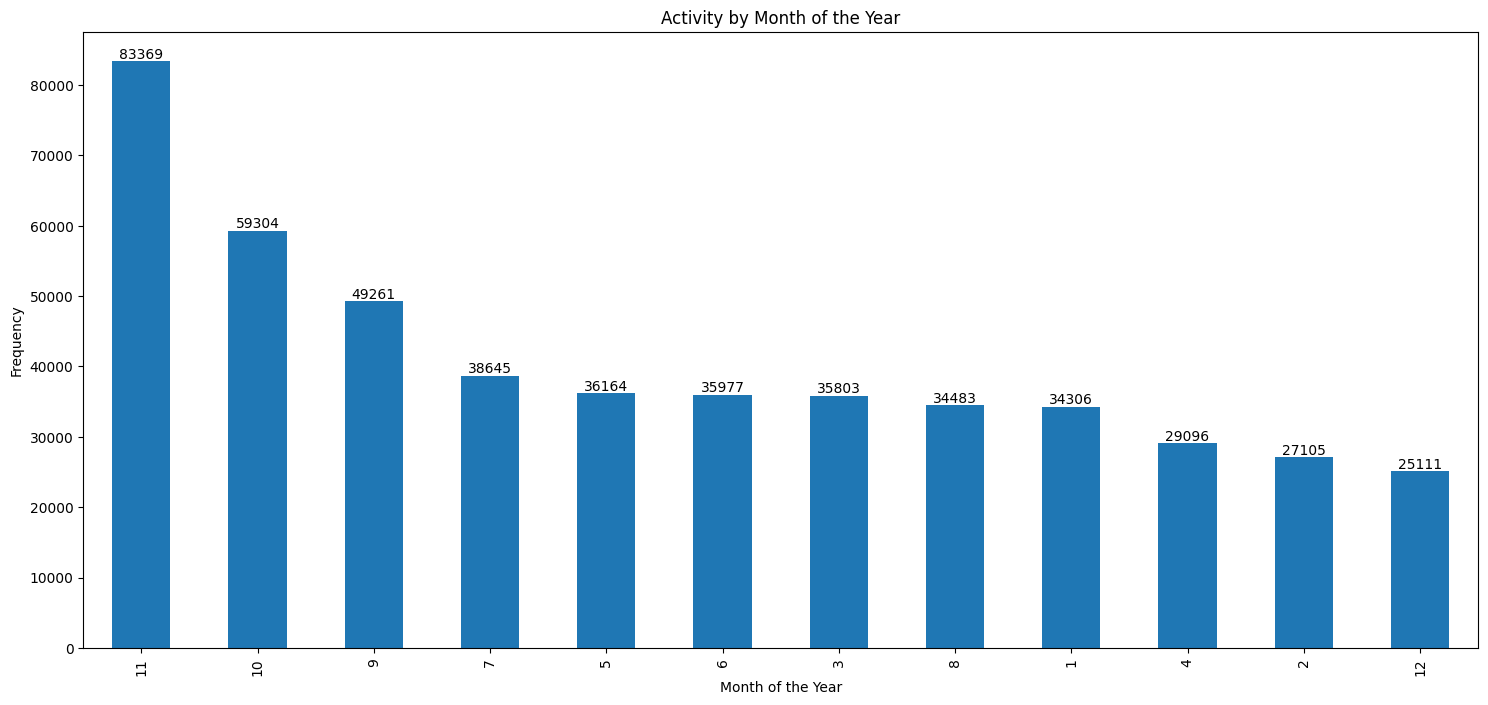

In [60]:
month_of_year_counts_2011 = year_2011['Month'].value_counts()

# Visualization
plt.figure(figsize = (18, 8))
month_of_year_counts_2011.plot(kind = 'bar', title = 'Activity by Month of the Year')
plt.xlabel('Month of the Year')
plt.ylabel('Frequency')

for i, value in enumerate(month_of_year_counts_2011):
    plt.text(i, value + 0.5, str(value), ha='center', va='bottom', fontsize=10)
    
plt.show()


In [61]:
start_date_2011 = year_2011['InvoiceDate'].min()  # Find the earliest date
end_date_2011 = year_2011['InvoiceDate'].max()    # Find the latest date

# Calculate the range (difference between start and end date)
date_range_2011 = end_date_2011 - start_date_2011

print(f"Start Date: {start_date_2011}")
print(f"End Date: {end_date_2011}")
print(f"Date Range: {date_range_2011}")

Start Date: 2011-01-04 10:00:00
End Date: 2011-12-09 12:50:00
Date Range: 339 days 02:50:00


- Invoices are generated only in one month that is in December
- Maybe the data is been collected from December 2010 and hence most of the data is available in 2011 

### Analyzing Day-of-Month Trends

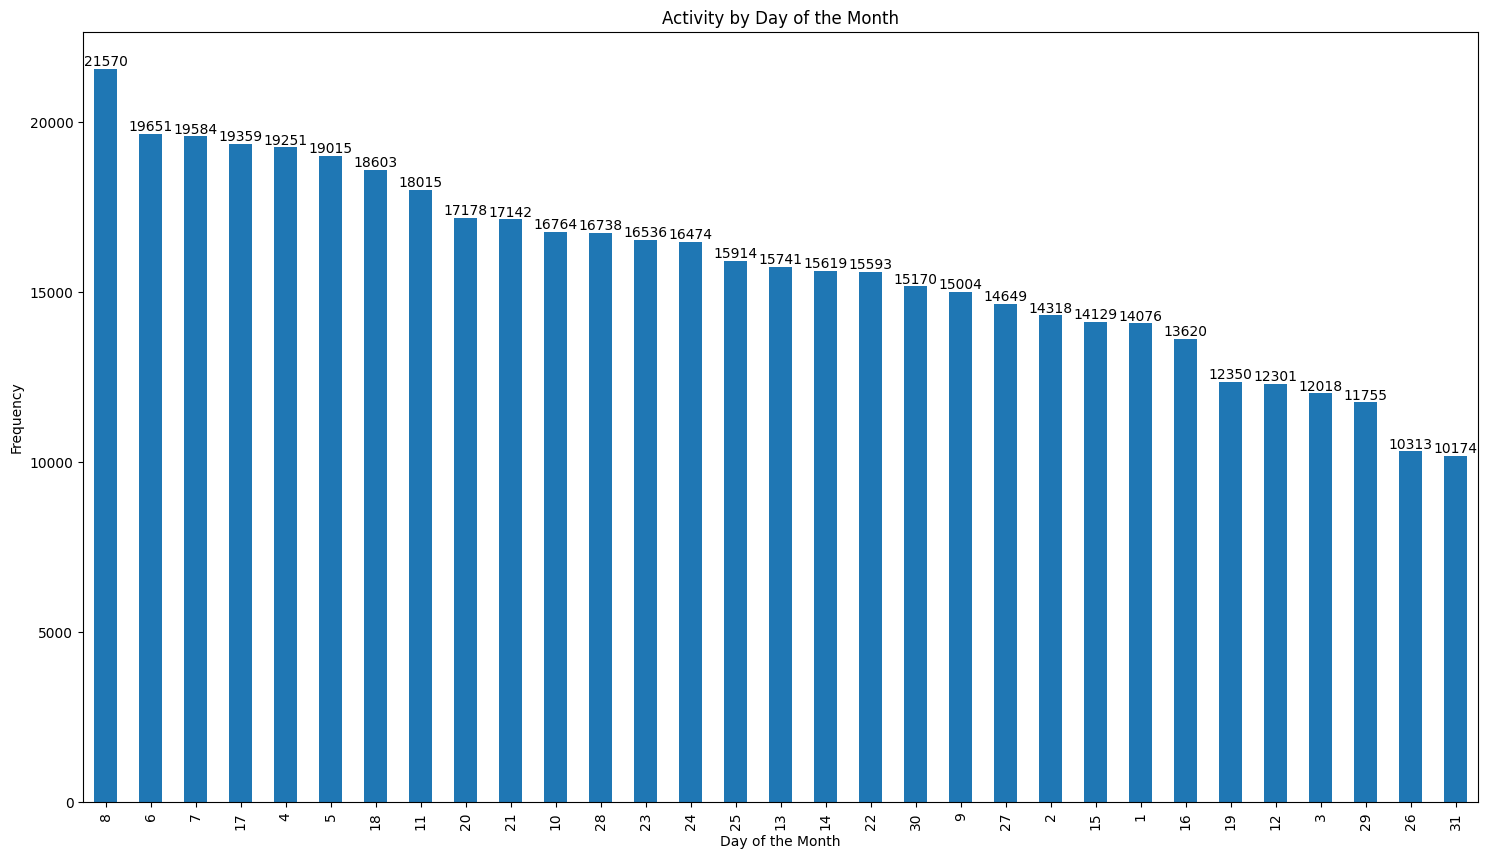

In [62]:
plt.figure(figsize=(18, 10))
Day_of_month_counts_2011 = year_2011['Day'].value_counts()

# Visualization
Day_of_month_counts_2011.plot(kind = 'bar', title = 'Activity by Day of the Month')
plt.xlabel('Day of the Month')
plt.ylabel('Frequency')

for i, value in enumerate(Day_of_month_counts_2011):
    plt.text(i, value + 0.5, str(value), ha='center', va='bottom', fontsize=10)
    
plt.show()


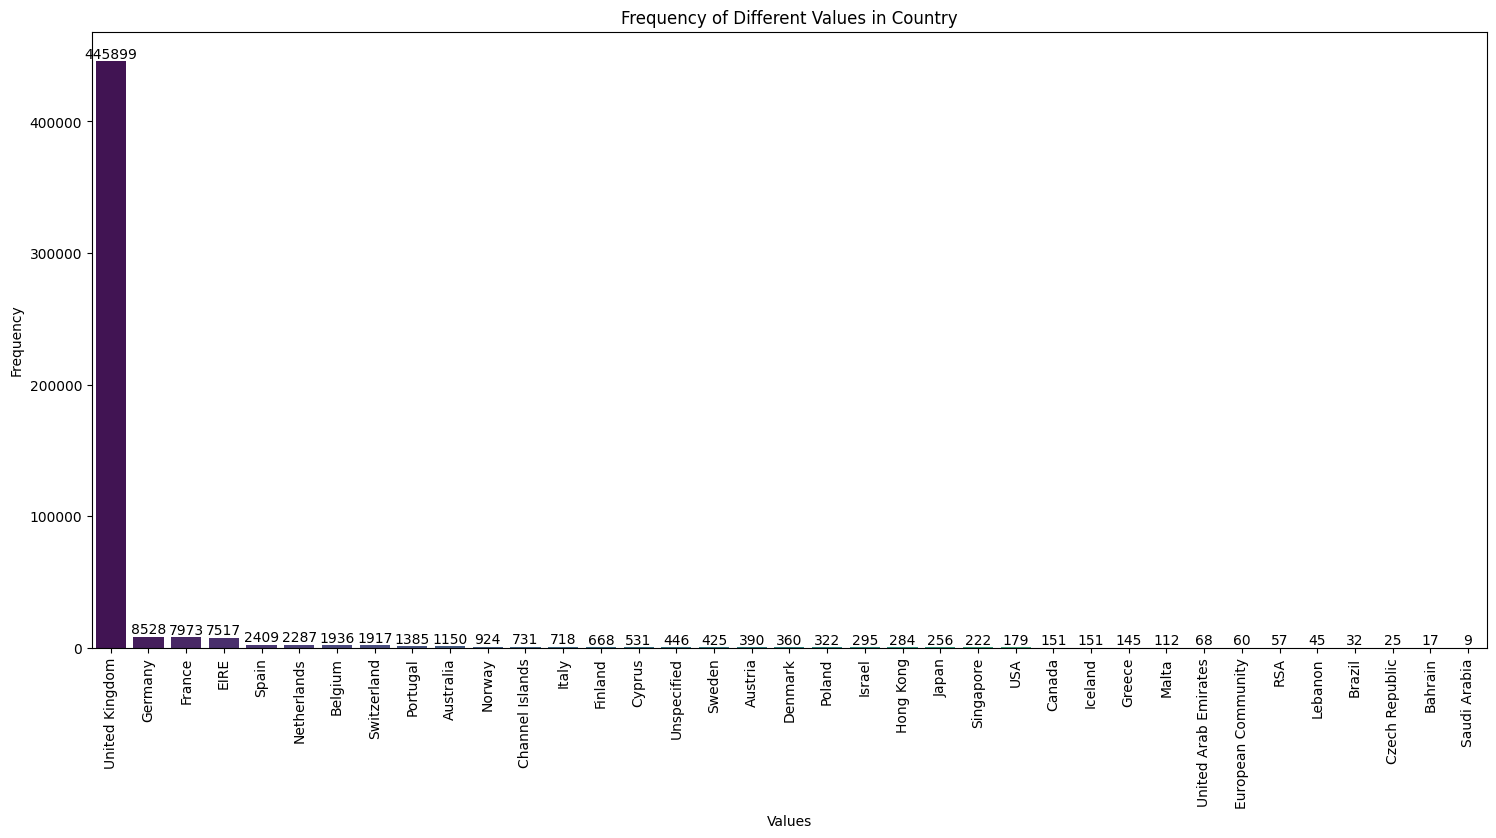

In [63]:
value_counts_2011 = year_2011['Country'].value_counts()

# Bar plot using Seaborn
plt.figure(figsize = (18, 8))
ax = sns.barplot(x = value_counts_2011.index, y = value_counts_2011.values, palette = "viridis")
plt.title('Frequency of Different Values in Country')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.xticks(rotation = 90)

# Add values on top of bars
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center', fontsize = 10, color = 'black', xytext = (0, 5), 
                textcoords = 'offset points')
plt.show()

### Lets have a check on what are the top keywords(Description) 

In [64]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

In [65]:
def clean_text(text, stop_words):
    # Ensure the input is a string before applying .lower()
    text = str(text).lower()

    # Remove non-alphanumeric characters
    text = re.sub(r"[^a-zA-Z\s]", "", text)
    
    # Split into words and filter stopwords
    words = [word for word in text.split() if word.isalnum() and word not in stop_words] 

    # Apply lemmatization
    words = [lemmatizer.lemmatize(word) for word in words]

    # Apply lemmatization
    words = [lemmatizer.lemmatize(word) for word in words]

    # Returning list of cleaned words
    return words 
    


In [66]:
# Apply the clean_text function to the Description column
year_2011['Cleaned_Description'] = year_2011['Description'].apply(lambda x: clean_text(x, stop_words))

# Convert list of words back into a single string for each row
year_2011['Cleaned_Description_Joined'] = year_2011['Cleaned_Description'].apply(lambda x: ' '.join(x))

# Filtering nan values
year_2011 = year_2011[year_2011['Cleaned_Description_Joined'] != 'nan']

In [67]:
year_2011.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Year,Month,Day,DayOfWeek,Hour,Cleaned_Description,Cleaned_Description_Joined
42481,539993,22386,JUMBO BAG PINK POLKADOT,10,2011-01-04 10:00:00,1.95,13313.0,United Kingdom,2011,1,4,Tuesday,10,"[jumbo, bag, pink, polkadot]",jumbo bag pink polkadot
42482,539993,21499,BLUE POLKADOT WRAP,25,2011-01-04 10:00:00,0.42,13313.0,United Kingdom,2011,1,4,Tuesday,10,"[blue, polkadot, wrap]",blue polkadot wrap
42483,539993,21498,RED RETROSPOT WRAP,25,2011-01-04 10:00:00,0.42,13313.0,United Kingdom,2011,1,4,Tuesday,10,"[red, retrospot, wrap]",red retrospot wrap
42484,539993,22379,RECYCLING BAG RETROSPOT,5,2011-01-04 10:00:00,2.10,13313.0,United Kingdom,2011,1,4,Tuesday,10,"[recycling, bag, retrospot]",recycling bag retrospot
42485,539993,20718,RED RETROSPOT SHOPPER BAG,10,2011-01-04 10:00:00,1.25,13313.0,United Kingdom,2011,1,4,Tuesday,10,"[red, retrospot, shopper, bag]",red retrospot shopper bag


In [68]:
year_2011.shape

(488624, 15)

### Get unigrams (single words)

In [69]:
# Tokenize the text into words for unigram analysis
all_words_2011 = [word for sublist in year_2011['Cleaned_Description_Joined'] for word in sublist.split()]
freq_unigrams_2011 = nltk.FreqDist(all_words_2011)

In [70]:
freq_unigrams_2011

FreqDist({'set': 58871, 'bag': 48920, 'heart': 40080, 'red': 38930, 'retrospot': 31624, 'vintage': 31375, 'design': 28073, 'pink': 27318, 'box': 24463, 'christmas': 22169, ...})

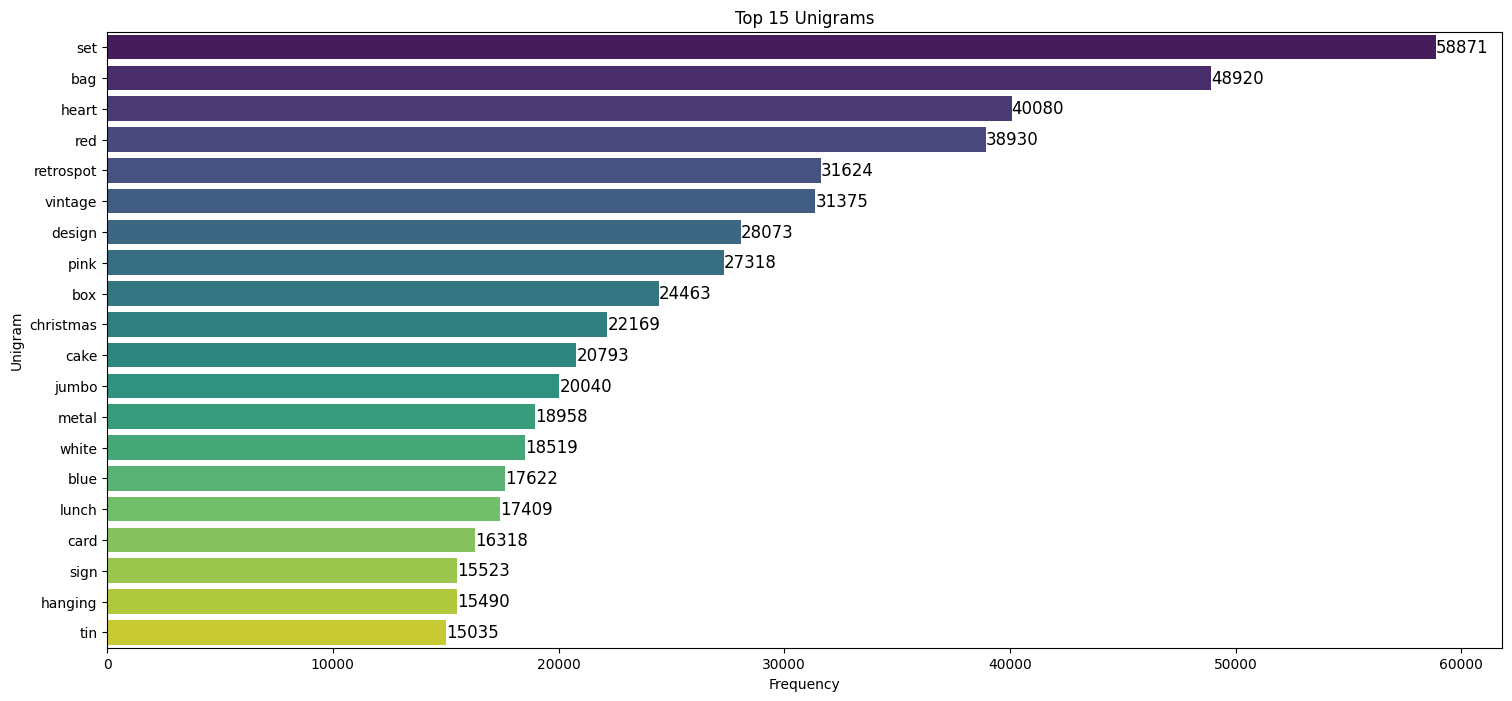

In [71]:
top_unigrams_2011 = freq_unigrams_2011.most_common(20)
top_unigrams_df_2011 = pd.DataFrame(top_unigrams_2011, columns=['Word', 'Frequency'])

# Plot the top unigrams
plt.figure(figsize=(18, 8))
ax = sns.barplot(x = 'Frequency', y = 'Word', data = top_unigrams_df_2011, palette = 'viridis')
plt.title('Top 15 Unigrams')
plt.xlabel('Frequency')
plt.ylabel('Unigram')

# Display the frequency on top of the bars
for i, v in enumerate(top_unigrams_df_2011['Frequency']):
    ax.text(v + 0.2, i, str(v), color='black', va='center', fontsize=12)

plt.show()

### Get bigrams (pairs of words)

In [72]:
# Generate bigrams
all_bigrams_2011 = list(ngrams(all_words_2011, 2))
freq_bigrams_2011 = nltk.FreqDist(all_bigrams_2011)

In [73]:
freq_bigrams_2011

FreqDist({('red', 'retrospot'): 17569, ('jumbo', 'bag'): 16261, ('lunch', 'bag'): 13124, ('metal', 'sign'): 11200, ('tlight', 'holder'): 10063, ('cake', 'case'): 8538, ('hot', 'water'): 7729, ('water', 'bottle'): 7729, ('dolly', 'girl'): 6403, ('vintage', 'christmas'): 5753, ...})

In [74]:
top_bigrams_2011 = freq_bigrams_2011.most_common(20)
top_bigrams_df_2011 = pd.DataFrame(top_bigrams_2011, columns=['Bigram', 'Frequency'])
top_bigrams_df_2011['Bigram'] = top_bigrams_df_2011['Bigram'].apply(lambda x: ' '.join(x))  

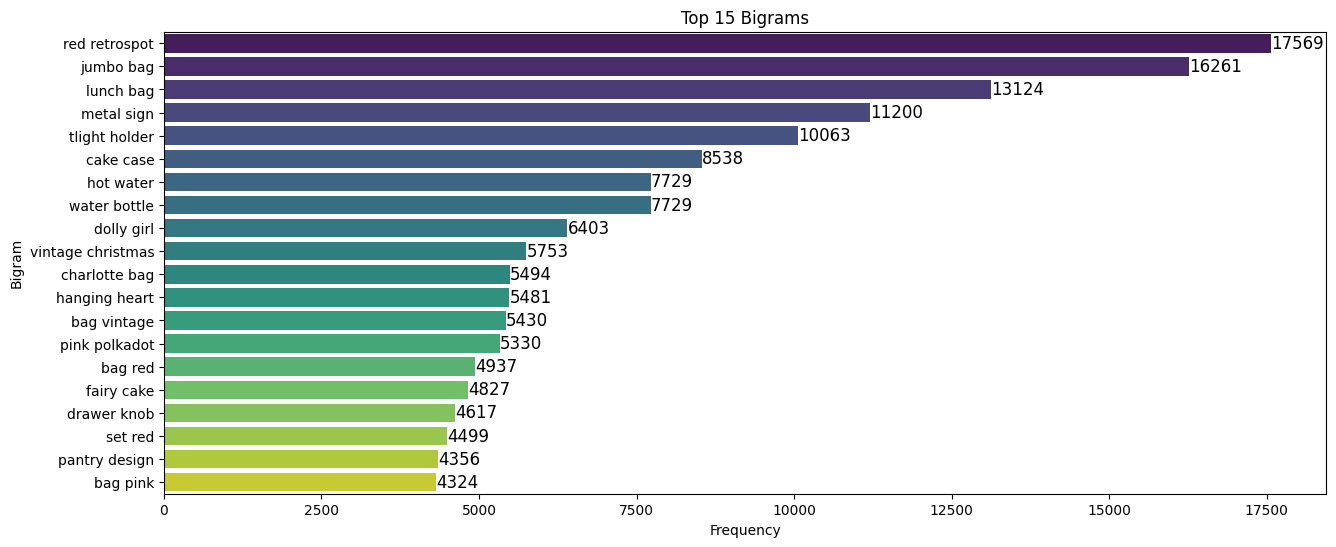

In [75]:
# Plot the top bigrams
plt.figure(figsize = (15, 6))
ax = sns.barplot(x = 'Frequency', y = 'Bigram', data = top_bigrams_df_2011, palette = 'viridis')
plt.title('Top 15 Bigrams')
plt.xlabel('Frequency')
plt.ylabel('Bigram')

# Display the frequency on top of the bars
for i, v in enumerate(top_bigrams_df_2011['Frequency']):
    ax.text(v + 0.2, i, str(v), color = 'black', va = 'center', fontsize = 12)

plt.show()

### Get trigrams (triples of words)

In [76]:
# Generate trigrams
all_trigrams_2011 = list(ngrams(all_words_2011, 3))
freq_trigrams_2011 = nltk.FreqDist(all_trigrams_2011)

In [77]:
freq_trigrams_2011

FreqDist({('hot', 'water', 'bottle'): 7729, ('bag', 'red', 'retrospot'): 4370, ('alarm', 'clock', 'bakelike'): 3904, ('home', 'sweet', 'home'): 3724, ('design', 'lunch', 'bag'): 3396, ('heart', 'tlight', 'holder'): 3268, ('travel', 'card', 'wallet'): 3093, ('bag', 'pink', 'polkadot'): 2976, ('paper', 'chain', 'kit'): 2877, ('hanging', 'heart', 'tlight'): 2843, ...})

In [78]:
top_trigrams_2011 = freq_trigrams_2011.most_common(15)
top_trigrams_df_2011 = pd.DataFrame(top_trigrams_2011, columns = ['Trigram', 'Frequency'])
top_trigrams_df_2011['Trigram'] = top_trigrams_df_2011['Trigram'].apply(lambda x: ' '.join(x))  # Convert tuple to string

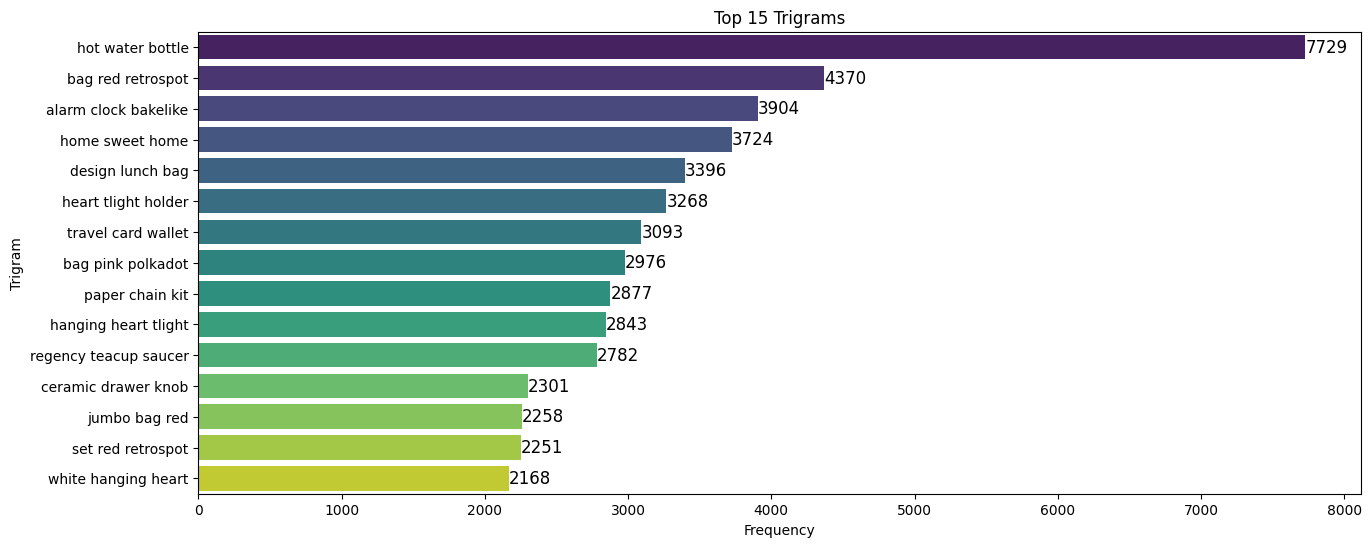

In [79]:
# Plot the top trigrams
plt.figure(figsize = (15, 6))
ax = sns.barplot(x = 'Frequency', y = 'Trigram', data = top_trigrams_df_2011, palette = 'viridis')
plt.title('Top 15 Trigrams')
plt.xlabel('Frequency')
plt.ylabel('Trigram')

# Display the frequency on top of the bars
for i, v in enumerate(top_trigrams_df_2011['Frequency']):
    ax.text(v + 0.2, i, str(v), color = 'black', va = 'center', fontsize = 12)

plt.show()

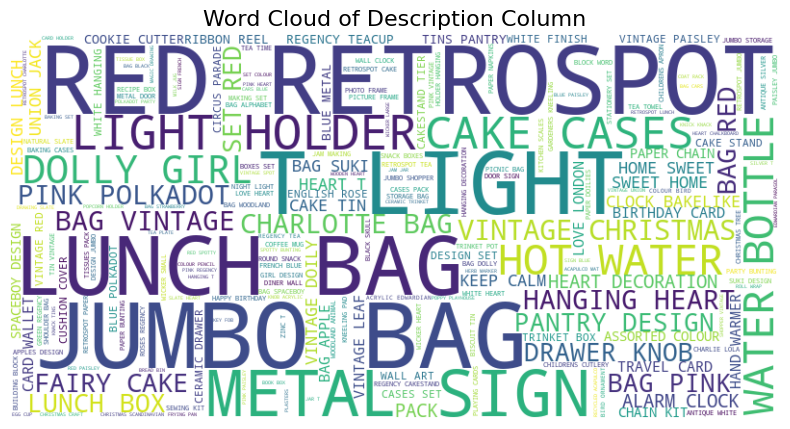

In [80]:
# Combine all sentences into a single string
text = " ".join(year_2011['Description'].dropna().astype(str))

# Generate a word cloud
wordcloud = WordCloud(width = 800, height = 400, background_color = 'white').generate(text)

# Display the word cloud
plt.figure(figsize = (10, 5))
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.title('Word Cloud of Description Column', fontsize = 16)
plt.show()

### Summary from the Text Analysis

- The data reveals that bags, decorative items, and household accessories are dominant product types in this dataset.
- Bags (e.g., jumbo bag, lunch bag, red retrospot) appear very frequently, often described with color or patterns like "retrospot" or "polkadot."
- Home decor items like "metal sign," "tlight holder," and "alarm clock" are also significant.
- There are recurring themes of vintage, Christmas decorations, and accessories, as seen in words like "vintage Christmas," "paper chain kit," and "home sweet home."
- The most frequent words, bigrams, and trigrams emphasize product descriptions and designs that likely resonate with decorative, vintage, and seasonal products.

### Comparing Decmber 2010 and December 2011 to check if we are able to find any similar patterns

In [81]:
dec_2011 = df[(df['Year'] == 2011) & (df['Month'] == 12)]

In [82]:
dec_2011.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Year,Month,Day,DayOfWeek,Hour
516403,579899,23301,GARDENERS KNEELING PAD KEEP CALM,24,2011-12-01 08:33:00,1.65,15687.0,United Kingdom,2011,12,1,Thursday,8
516404,579899,22623,BOX OF VINTAGE JIGSAW BLOCKS,3,2011-12-01 08:33:00,5.95,15687.0,United Kingdom,2011,12,1,Thursday,8
516405,579899,20970,PINK FLORAL FELTCRAFT SHOULDER BAG,4,2011-12-01 08:33:00,3.75,15687.0,United Kingdom,2011,12,1,Thursday,8
516406,579899,23562,SET OF 6 RIBBONS PERFECTLY PRETTY,6,2011-12-01 08:33:00,2.89,15687.0,United Kingdom,2011,12,1,Thursday,8
516407,579899,71477,COLOURED GLASS STAR T-LIGHT HOLDER,4,2011-12-01 08:33:00,3.95,15687.0,United Kingdom,2011,12,1,Thursday,8


In [83]:
dec_2011['Month'].unique()

array([12], dtype=int32)

In [84]:
dec_2011['Year'].unique()

array([2011], dtype=int32)

In [85]:
dec_2011.shape

(25111, 13)

In [86]:
dec_2011.describe()

,Quantity,InvoiceDate,UnitPrice,CustomerID,Year,Month,Day,Hour
count,25111.000000,25111,25111.000000,17304.000000,25111.0,25111.0,25111.000000,25111.00000
mean,12.514356,2011-12-05 20:37:56.709808384,4.044432,15314.034732,2011.0,12.0,5.293975,13.09004
min,1.000000,2011-12-01 08:33:00,0.040000,12347.000000,2011.0,12.0,1.000000,8.00000
25%,1.000000,2011-12-04 12:32:00,1.250000,14023.000000,2011.0,12.0,4.000000,11.00000
50%,3.000000,2011-12-05 17:28:00,2.080000,15033.000000,2011.0,12.0,5.000000,13.00000
75%,10.000000,2011-12-08 09:20:00,4.130000,16910.000000,2011.0,12.0,8.000000,16.00000
max,80995.000000,2011-12-09 12:50:00,2196.670000,18283.000000,2011.0,12.0,9.000000,20.00000
std,512.199787,NaN,34.257106,1725.079539,0.0,0.0,2.467857,2.75021


In [87]:
dec_2011.info()

<class 'pandas.core.frame.DataFrame'>
Index: 25111 entries, 516403 to 541908
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   InvoiceNo    25111 non-null  object        
 1   StockCode    25111 non-null  object        
 2   Description  25111 non-null  object        
 3   Quantity     25111 non-null  int64         
 4   InvoiceDate  25111 non-null  datetime64[ns]
 5   UnitPrice    25111 non-null  float64       
 6   CustomerID   17304 non-null  float64       
 7   Country      25111 non-null  object        
 8   Year         25111 non-null  int32         
 9   Month        25111 non-null  int32         
 10  Day          25111 non-null  int32         
 11  DayOfWeek    25111 non-null  object        
 12  Hour         25111 non-null  int32         
dtypes: datetime64[ns](1), float64(2), int32(4), int64(1), object(5)
memory usage: 2.3+ MB


### Analyzing Day-of-Week Trends

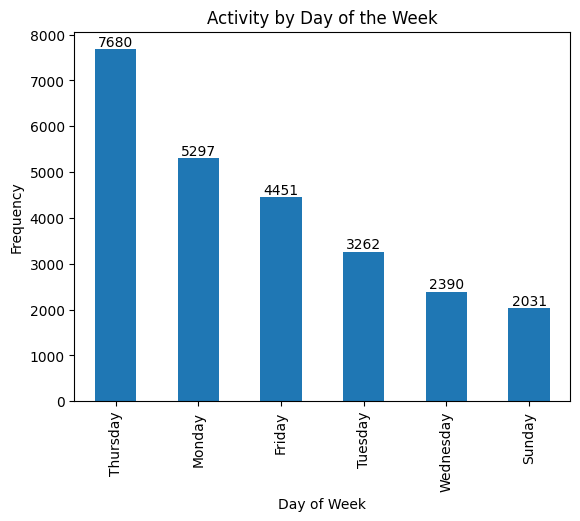

In [88]:
day_of_week_counts_dec_2011 = dec_2011['DayOfWeek'].value_counts()

# Visualization
day_of_week_counts_dec_2011.plot(kind = 'bar', title = 'Activity by Day of the Week')
plt.xlabel('Day of Week')
plt.ylabel('Frequency')

for i, value in enumerate(day_of_week_counts_dec_2011):
    plt.text(i, value + 0.5, str(value), ha='center', va='bottom', fontsize=10)
    
plt.show()


- When compared to December 2010, the highest number of transactions in a single day decreased from **7,941 in 2010** to **7,680 in 2011**.
- The total number of transactions (invoices generated) dropped from **41,480 in December 2010** to **25,111 in December 2011**.
- Purchases in December 2011 were significantly lower than in December 2010, reflecting a **39.46% decrease**.
- A consistent trend observed in both years is the absence of invoices generated on Saturdays, while Sundays recorded the lowest number of transactions. This indicates that transactions were notably higher on weekdays compared to weekends.

### Analyzing Day-of-Month Trends

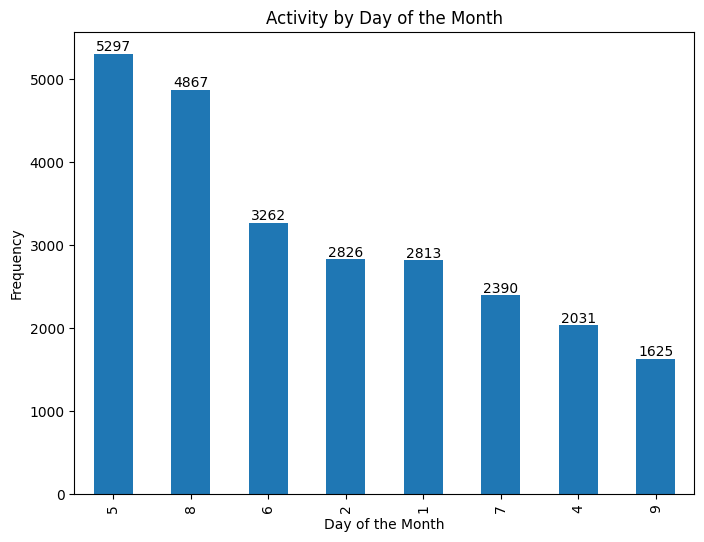

In [89]:
plt.figure(figsize=(8, 6))
Day_of_month_counts_dec_2011 = dec_2011['Day'].value_counts()

# Visualization
Day_of_month_counts_dec_2011.plot(kind = 'bar', title = 'Activity by Day of the Month')
plt.xlabel('Day of the Month')
plt.ylabel('Frequency')

for i, value in enumerate(Day_of_month_counts_dec_2011):
    plt.text(i, value + 0.5, str(value), ha='center', va='bottom', fontsize=10)
    
plt.show()


In December 2010, transactions occurred on 20 days of the month, whereas in December 2011, transactions were recorded on only 8 days of the month.

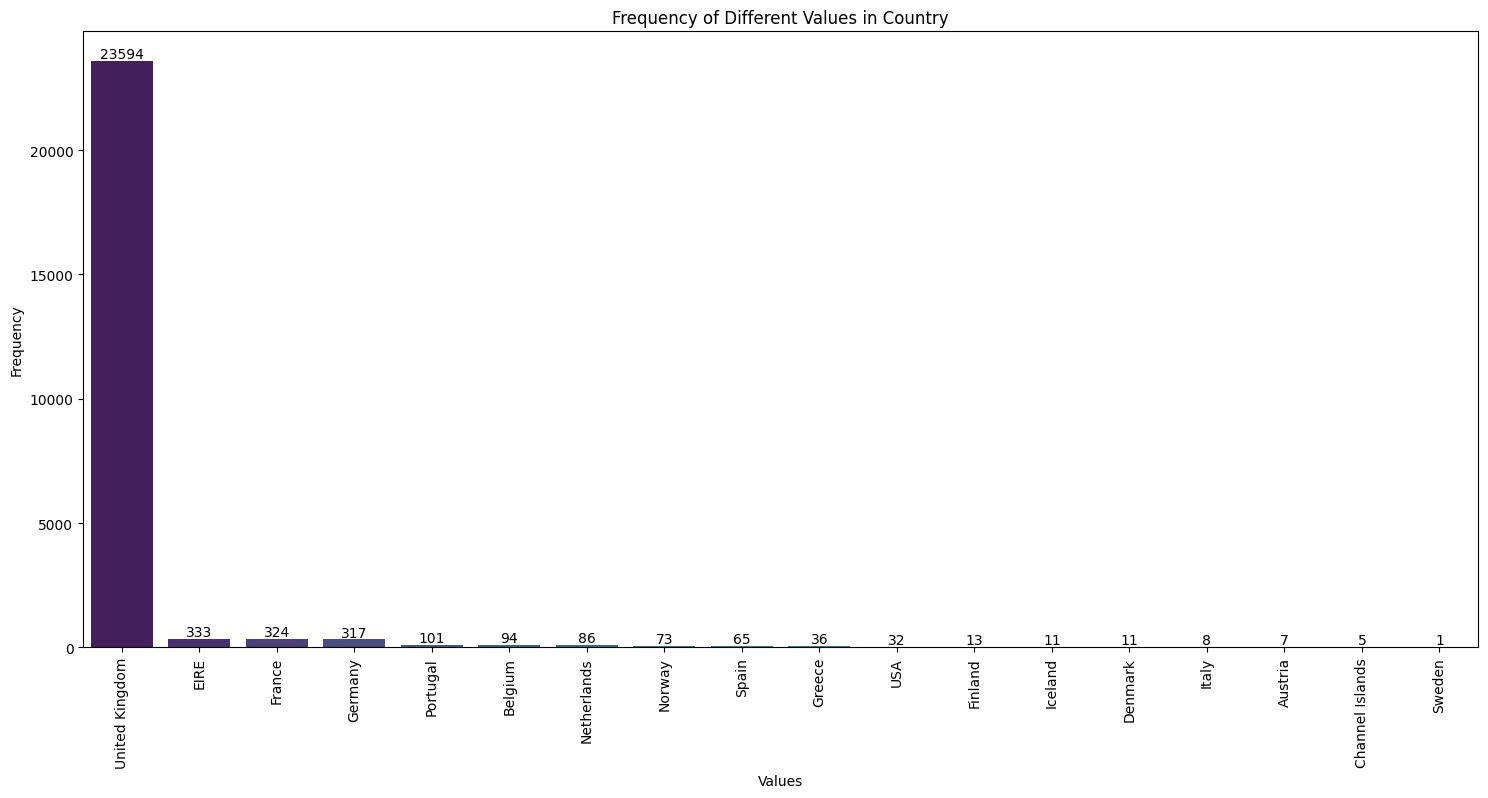

In [90]:
value_counts_dec_2011 = dec_2011['Country'].value_counts()

# Bar plot using Seaborn
plt.figure(figsize = (18, 8))
ax = sns.barplot(x = value_counts_dec_2011.index, y = value_counts_dec_2011.values, palette = "viridis")
plt.title('Frequency of Different Values in Country')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.xticks(rotation = 90)

# Add values on top of bars
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center', fontsize = 10, color = 'black', xytext = (0, 5), 
                textcoords = 'offset points')
plt.show()

- The **UK** recorded the highest number of invoices in both December 2010 and December 2011; however, the number of invoices dropped significantly from **39,224** in December 2010 to **23,594** in December 2011.
- **Germany**, which held the **second position** in December 2010, dropped to the **4th position** in December 2011, with invoices declining from **512 to 317**.
- Several countries, including **Cyprus, Japan, Switzerland, Lithuania, Australia, Poland, and Bahrain** which had transactions in December 2010, recorded **no transactions** in December 2011.
- Notably, **Greece**, which had **no transactions** in December 2010, **recorded about 36 transactions** in December 2011.

### Lets have a check on what are the top keywords(Description)

In [91]:
# Apply the clean_text function to the Description column
dec_2011['Cleaned_Description'] = dec_2011['Description'].apply(lambda x: clean_text(x, stop_words))

# Convert list of words back into a single string for each row
dec_2011['Cleaned_Description_Joined'] = dec_2011['Cleaned_Description'].apply(lambda x: ' '.join(x))

# Filtering nan values
dec_2011 = dec_2011[dec_2011['Cleaned_Description_Joined'] != 'nan']

In [92]:
dec_2011.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Year,Month,Day,DayOfWeek,Hour,Cleaned_Description,Cleaned_Description_Joined
516403,579899,23301,GARDENERS KNEELING PAD KEEP CALM,24,2011-12-01 08:33:00,1.65,15687.0,United Kingdom,2011,12,1,Thursday,8,"[gardener, kneeling, pad, keep, calm]",gardener kneeling pad keep calm
516404,579899,22623,BOX OF VINTAGE JIGSAW BLOCKS,3,2011-12-01 08:33:00,5.95,15687.0,United Kingdom,2011,12,1,Thursday,8,"[box, vintage, jigsaw, block]",box vintage jigsaw block
516405,579899,20970,PINK FLORAL FELTCRAFT SHOULDER BAG,4,2011-12-01 08:33:00,3.75,15687.0,United Kingdom,2011,12,1,Thursday,8,"[pink, floral, feltcraft, shoulder, bag]",pink floral feltcraft shoulder bag
516406,579899,23562,SET OF 6 RIBBONS PERFECTLY PRETTY,6,2011-12-01 08:33:00,2.89,15687.0,United Kingdom,2011,12,1,Thursday,8,"[set, ribbon, perfectly, pretty]",set ribbon perfectly pretty
516407,579899,71477,COLOURED GLASS STAR T-LIGHT HOLDER,4,2011-12-01 08:33:00,3.95,15687.0,United Kingdom,2011,12,1,Thursday,8,"[coloured, glass, star, tlight, holder]",coloured glass star tlight holder


In [93]:
dec_2011.shape

(25111, 15)

### Get unigrams (single words)

In [94]:
# Tokenize the text into words for unigram analysis
all_words_dec_2011 = [word for sublist in dec_2011['Cleaned_Description_Joined'] for word in sublist.split()]
freq_unigrams_dec_2011 = nltk.FreqDist(all_words_dec_2011)

In [95]:
freq_unigrams_dec_2011

FreqDist({'set': 2989, 'christmas': 2066, 'vintage': 1964, 'heart': 1957, 'bag': 1903, 'red': 1855, 'design': 1327, 'retrospot': 1276, 'box': 1235, 'pink': 1090, ...})

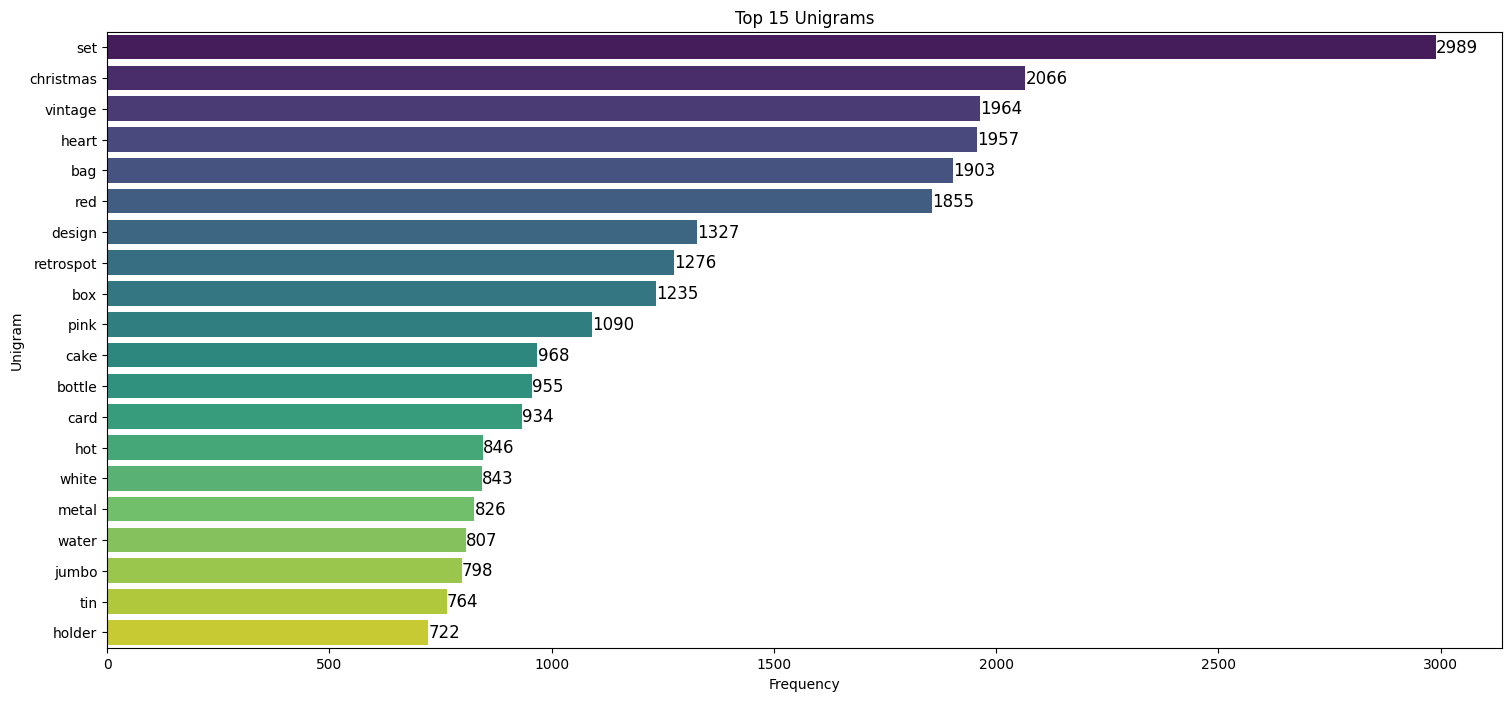

In [96]:
freq_unigrams_dec_2011 = freq_unigrams_dec_2011.most_common(20)
top_unigrams_dec_2011 = pd.DataFrame(freq_unigrams_dec_2011, columns=['Word', 'Frequency'])

# Plot the top unigrams
plt.figure(figsize=(18, 8))
ax = sns.barplot(x = 'Frequency', y = 'Word', data = top_unigrams_dec_2011, palette = 'viridis')
plt.title('Top 15 Unigrams')
plt.xlabel('Frequency')
plt.ylabel('Unigram')

# Display the frequency on top of the bars
for i, v in enumerate(top_unigrams_dec_2011['Frequency']):
    ax.text(v + 0.2, i, str(v), color='black', va='center', fontsize=12)

plt.show()

The unigram indicates that decorative items(metals, sign, holder) household accessories(bottle, box), seasonal and festive products(Christmas, cake) dominate the product descriptions.

### Get bigrams (pairs of words)

In [97]:
# Generate bigrams
all_bigrams_dec_2011 = list(ngrams(all_words_dec_2011, 2))
freq_bigrams_dec_2011 = nltk.FreqDist(all_bigrams_dec_2011)

In [98]:
freq_bigrams_dec_2011

FreqDist({('hot', 'water'): 791, ('water', 'bottle'): 791, ('jumbo', 'bag'): 649, ('red', 'retrospot'): 605, ('vintage', 'christmas'): 572, ('metal', 'sign'): 495, ('tlight', 'holder'): 492, ('lunch', 'bag'): 478, ('hand', 'warmer'): 379, ('vintage', 'doily'): 350, ...})

- The bigrams highlight a clear focus on decorative("metal sign,", "tlight holder", "hanging heart"), seasonal("ribbon reel", "hand warmer"), and household products("hot water", "water bottle", "plaster tin", "lunch bag", "lunch box"), often described with functional or aesthetic keywords.
- Overall, the bigrams emphasize a mix of functional household goods, decorative products, and festive or vintage-themed items that likely cater to daily, seasonal, and gifting needs.

In [99]:
top_bigrams_dec_2011 = freq_bigrams_dec_2011.most_common(20)
top_bigrams_df_dec_2011 = pd.DataFrame(top_bigrams_dec_2011, columns=['Bigram', 'Frequency'])
top_bigrams_df_dec_2011['Bigram'] = top_bigrams_df_dec_2011['Bigram'].apply(lambda x: ' '.join(x))  

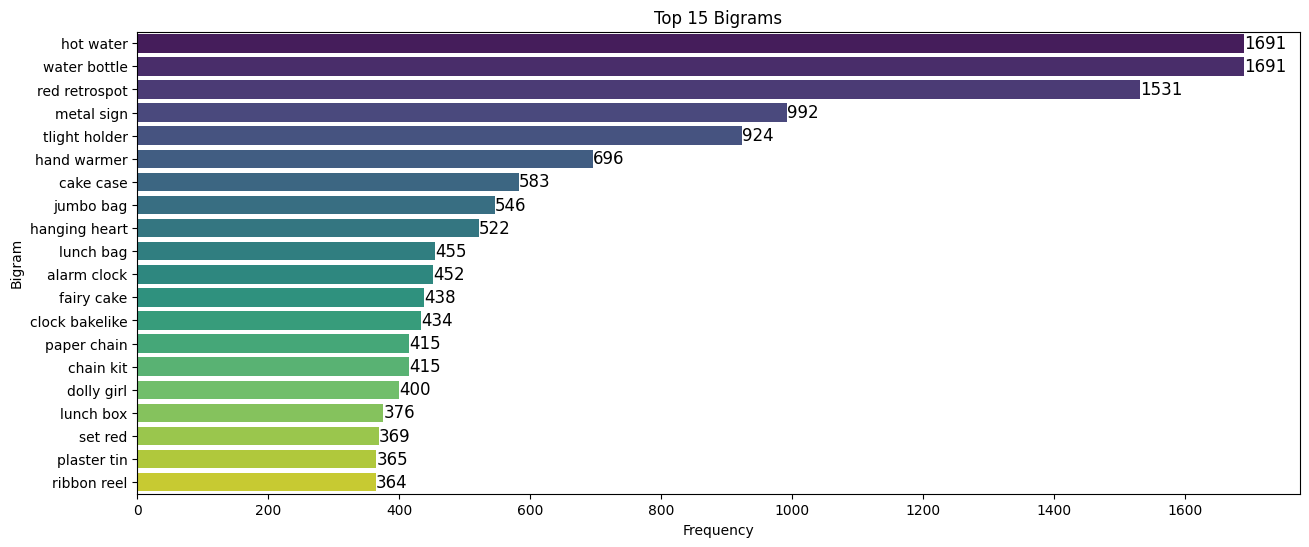

In [100]:
# Plot the top bigrams
plt.figure(figsize = (15, 6))
ax = sns.barplot(x = 'Frequency', y = 'Bigram', data = top_bigrams_df_2010, palette = 'viridis')
plt.title('Top 15 Bigrams')
plt.xlabel('Frequency')
plt.ylabel('Bigram')

# Display the frequency on top of the bars
for i, v in enumerate(top_bigrams_df_2010['Frequency']):
    ax.text(v + 0.2, i, str(v), color = 'black', va = 'center', fontsize = 12)

plt.show()

### Get trigrams (triples of words)

In [101]:
# Generate trigrams
all_trigrams_2010 = list(ngrams(all_words_2010, 3))
freq_trigrams_2010 = nltk.FreqDist(all_trigrams_2010)

In [102]:
freq_trigrams_2010

FreqDist({('hot', 'water', 'bottle'): 1691, ('alarm', 'clock', 'bakelike'): 434, ('paper', 'chain', 'kit'): 415, ('heart', 'tlight', 'holder'): 358, ('hanging', 'heart', 'tlight'): 327, ('bag', 'red', 'retrospot'): 279, ('jam', 'making', 'set'): 248, ('heart', 'hot', 'water'): 243, ('white', 'hanging', 'heart'): 239, ('magic', 'drawing', 'slate'): 221, ...})

In [103]:
top_trigrams_2010 = freq_trigrams_2010.most_common(15)
top_trigrams_df_2010 = pd.DataFrame(top_trigrams_2010, columns = ['Trigram', 'Frequency'])
top_trigrams_df_2010['Trigram'] = top_trigrams_df_2010['Trigram'].apply(lambda x: ' '.join(x))  # Convert tuple to string

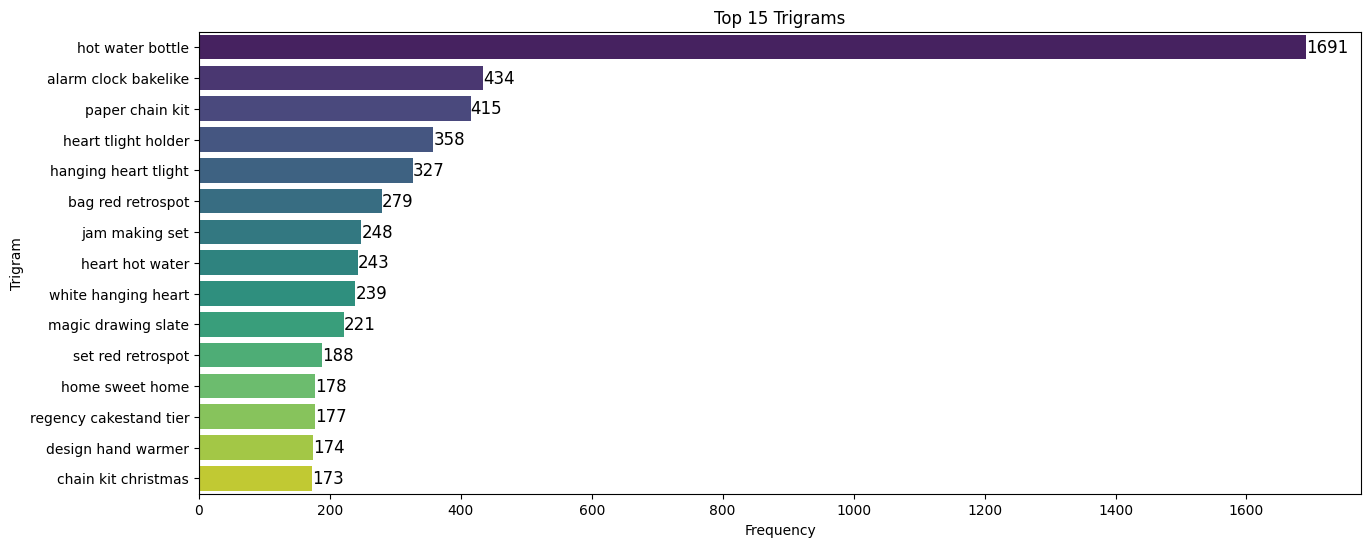

In [104]:
# Plot the top trigrams
plt.figure(figsize = (15, 6))
ax = sns.barplot(x = 'Frequency', y = 'Trigram', data = top_trigrams_df_2010, palette = 'viridis')
plt.title('Top 15 Trigrams')
plt.xlabel('Frequency')
plt.ylabel('Trigram')

# Display the frequency on top of the bars
for i, v in enumerate(top_trigrams_df_2010['Frequency']):
    ax.text(v + 0.2, i, str(v), color = 'black', va = 'center', fontsize = 12)

plt.show()

The trigrams provide deeper insights into the products, emphasizing functional, decorative, and festive items with vintage and themed designs.

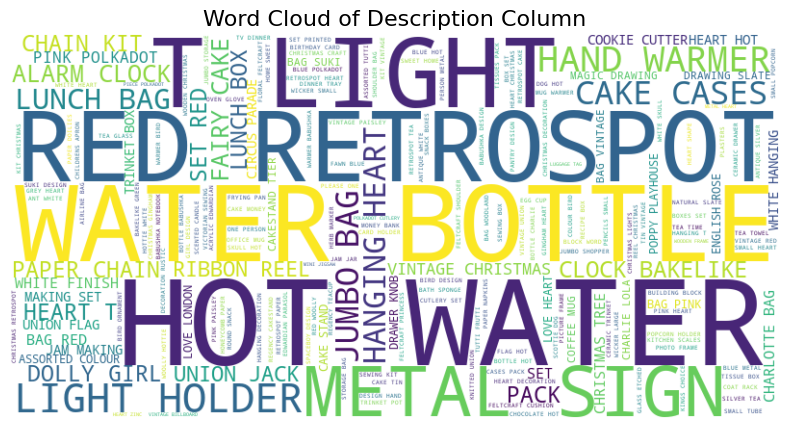

In [105]:
# Combine all sentences into a single string
text = " ".join(year_2010['Description'].dropna().astype(str))

# Generate a word cloudz
wordcloud = WordCloud(width = 800, height = 400, background_color = 'white').generate(text)

# Display the word cloud
plt.figure(figsize = (10, 5))
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.title('Word Cloud of Description Column', fontsize = 16)
plt.show()

The word cloud, unigram, bigram and trigram all of them show that the words are related to decorative, seasonal, festive, vintage, themed designs

### Some observations from this exploratory data analysis

- Even in this subset of data, there is **75 % null value in CustomerID**
- **92 %** audience is from **United Kingdom**
- **92 %** of the **Invoices** are generated in the **year 2011**
- The data distribution for **Quantity** and **UnitPrice** shows that both the distributions are **highly skewed**
- Further investigation into the data distribution shows that **outliers** are present in both the **Quantity** and **UnitPrice** variables **beyond the 90th percentile**
- The **Quantity** variable contains approximately **11 %** outliers, while the **UnitPrice** variable has **7 %** outliers.
- For **2010**, **Invoices** were generated only on **December**, so it seems data was started collecting from December 2010
- For **December 2010** the keywords analysis shows that, the **words are related to decorative, seasonal, festive, vintage, themed designs**
- For the year **2011** the keywords analysis shows that, the words **emphasize product descriptions and designs that likely resonate with decorative, vintage, and seasonal products.**
- Comparing the December month of both the years, in **December 2011**, **transactions dropped** by **39.46%** from **41,480** to **25,111**, with the **highest daily transactions** declining from **7,941** to **7,680**. Transactions were consistently higher on weekdays, with no activity on Saturdays and minimal activity on Sundays.
- The **UK remained the leader** in invoices across **both years**, though with a noticeable decline in activity. **Germany's ranking dropped**.
- Several countries, including **Cyprus, Japan, Switzerland, Lithuania, Australia, Poland, and Bahrain** which had transactions in December 2010, recorded no transactions in December 2011, while **Greece** made its first appearance with **36 transactions**.